In [1]:
# remove the notebook root logger.\n",
import logging
logger = logging.getLogger()
logger.handlers = []

In [2]:
import pandas as pd

# Hierarchical Forecasting with PyAF

In this document , we give a use case of hierarchcial forecasting wioth PyAF. 

We study the problem of forecasting France wine exportation by wine type (Champagne , Bordeaux, etc), variant (red , white, sparkling etc) and destination country.

A dataset has been built based on French government opendata gratefully provided by the foreign trade ministry. This dataset is available here : https://github.com/antoinecarme/TimeSeriesData/tree/master/Stat_FR_CommExt. 

Please note that the original dataset is generic and contains export data for all foreign trade products to all possible countries with a significant level of detail (cars, crops, living animals , legal weapons , ...).



## Data Overview

The dataset is a collection of 2872 monthly time series overserved on a period ranging from 2012-01-01 to 2016-09-01.

Each time series has 50 rows (some data are missing in 2015 , under investigation) and represents the export of a given type of wine, a given variant to a unique contry.

The time series column name is built by concatenating the three above informations.

To simplify, we will reduce the number of countries to the 10 most signficant (`wine-friendly`) ones. This reduces the number of columns to 176 ;)

In [3]:
import datetime

filename = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/Stat_FR_CommExt/merged/French_Wine_Export_in_Euros_Some_Countries.csv"

French_Wine_Export_in_Euros_DF = pd.read_csv(filename);

lDateColumn = 'Month';
French_Wine_Export_in_Euros_DF[lDateColumn] = French_Wine_Export_in_Euros_DF[lDateColumn].apply(lambda x : datetime.datetime.strptime(str(x), "%Y-%m-%d"))

French_Wine_Export_in_Euros_DF.head(5)


,Month,ALSACE_BLANC_BE,ALSACE_BLANC_CA,ALSACE_BLANC_CH,ALSACE_BLANC_CN,ALSACE_BLANC_DE,ALSACE_BLANC_GB,ALSACE_BLANC_HK,ALSACE_BLANC_JP,ALSACE_BLANC_NL,...,RHÔNE_ROUGE_CA,RHÔNE_ROUGE_CH,RHÔNE_ROUGE_CN,RHÔNE_ROUGE_DE,RHÔNE_ROUGE_GB,RHÔNE_ROUGE_HK,RHÔNE_ROUGE_JP,RHÔNE_ROUGE_NL,RHÔNE_ROUGE_OTHER,RHÔNE_ROUGE_US
0,2012-01-01,1131852,571940,257116,140013,357516,344274,51043,329883,624695,...,800628,650236,1127393,783952,1513332,335710,916965,314654,35418,1260510
1,2012-02-01,857289,585556,187917,89805,505896,424953,80220,239242,899144,...,795356,680567,188827,868576,1277664,197072,318522,516140,36604,2136484
2,2012-03-01,1438501,834142,679281,103577,583887,352675,102980,394945,1093638,...,873858,1318538,856382,627236,2343448,132200,605914,410308,43197,3264810
3,2012-04-01,986602,866221,523202,203456,515903,403517,52773,260953,874217,...,1004028,919493,460815,829432,1861188,128164,472522,290407,45396,2631466
4,2012-05-01,991668,1061702,611369,80327,767522,627232,78115,680323,994697,...,2098300,632778,239200,934532,2215922,202210,337894,284868,41469,2945175


In [4]:
French_Wine_Export_in_Euros_DF.describe()

,ALSACE_BLANC_BE,ALSACE_BLANC_CA,ALSACE_BLANC_CH,ALSACE_BLANC_CN,ALSACE_BLANC_DE,ALSACE_BLANC_GB,ALSACE_BLANC_HK,ALSACE_BLANC_JP,ALSACE_BLANC_NL,ALSACE_BLANC_OTHER,...,RHÔNE_ROUGE_CA,RHÔNE_ROUGE_CH,RHÔNE_ROUGE_CN,RHÔNE_ROUGE_DE,RHÔNE_ROUGE_GB,RHÔNE_ROUGE_HK,RHÔNE_ROUGE_JP,RHÔNE_ROUGE_NL,RHÔNE_ROUGE_OTHER,RHÔNE_ROUGE_US
count,5.000000e+01,5.000000e+01,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01,50.000000,...,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,50.000000,5.000000e+01
mean,1.189956e+06,8.037735e+05,428923.380000,119348.360000,6.173951e+05,414037.100000,88636.820000,361437.900000,8.035454e+05,38337.801569,...,1.607702e+06,8.523710e+05,7.498312e+05,1.072562e+06,2.876061e+06,235678.640000,5.760031e+05,4.986103e+05,52907.080000,2.912355e+06
std,2.780384e+05,1.691507e+05,158179.648178,65116.609016,2.765474e+05,116398.158498,68347.582681,110140.042643,2.732401e+05,6088.988573,...,7.064099e+05,2.458533e+05,3.592653e+05,4.307817e+05,1.366642e+06,140071.773582,2.398091e+05,1.720202e+05,9667.885799,6.675896e+05
min,5.477480e+05,3.514620e+05,88329.000000,19546.000000,3.131500e+05,168388.000000,31864.000000,192553.000000,3.085880e+05,18550.156250,...,7.935600e+05,3.992940e+05,1.888270e+05,5.558550e+05,1.277664e+06,77550.000000,2.053840e+05,2.311020e+05,35238.000000,1.260510e+06
25%,1.004816e+06,6.791068e+05,316753.500000,82278.500000,4.801042e+05,333264.500000,52845.750000,293690.250000,6.061862e+05,35457.417067,...,1.047350e+06,6.819278e+05,5.089532e+05,7.219495e+05,2.025437e+06,152307.750000,3.751060e+05,3.725818e+05,46721.000000,2.500847e+06
50%,1.161726e+06,8.070940e+05,445554.500000,98656.000000,5.449660e+05,401774.500000,76561.500000,335180.000000,7.884350e+05,38715.394123,...,1.506712e+06,8.120535e+05,7.065070e+05,9.246160e+05,2.519672e+06,203395.000000,5.414685e+05,4.674045e+05,52305.000000,2.896628e+06
75%,1.323582e+06,8.880218e+05,542924.000000,161694.000000,6.549058e+05,515408.000000,102011.750000,417475.000000,8.980862e+05,41900.001008,...,1.936743e+06,1.023269e+06,9.285735e+05,1.207832e+06,3.018630e+06,257873.500000,7.998980e+05,6.143272e+05,59756.250000,3.380802e+06
max,2.166585e+06,1.216720e+06,857207.000000,317661.000000,1.871515e+06,635447.000000,510151.000000,680323.000000,1.458234e+06,52823.280702,...,3.946934e+06,1.334550e+06,1.755449e+06,2.312776e+06,8.652432e+06,879037.000000,1.076535e+06,1.063568e+06,71487.000000,4.664273e+06


To give an example, the following plot compares the export of Champagne to Germany, Japan and UK:  

In [5]:
%matplotlib inline

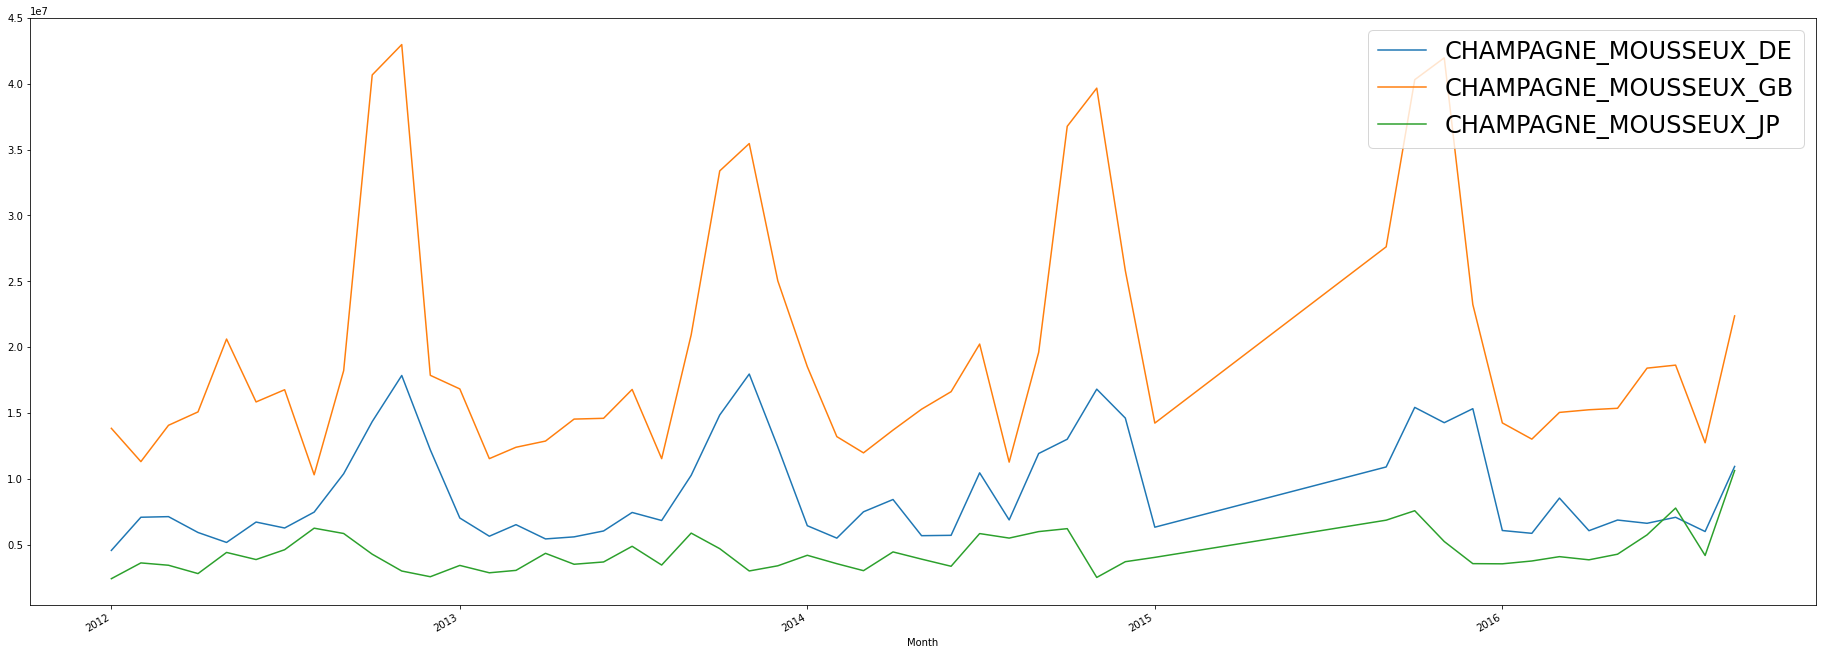

In [6]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['CHAMPAGNE_MOUSSEUX_DE', 'CHAMPAGNE_MOUSSEUX_GB' , 'CHAMPAGNE_MOUSSEUX_JP'],
                                   figsize=(32 , 12)).legend(loc='best', fontsize=24)

While the next one compares US consumption (in Euros) of red and white Bordeaux ;)

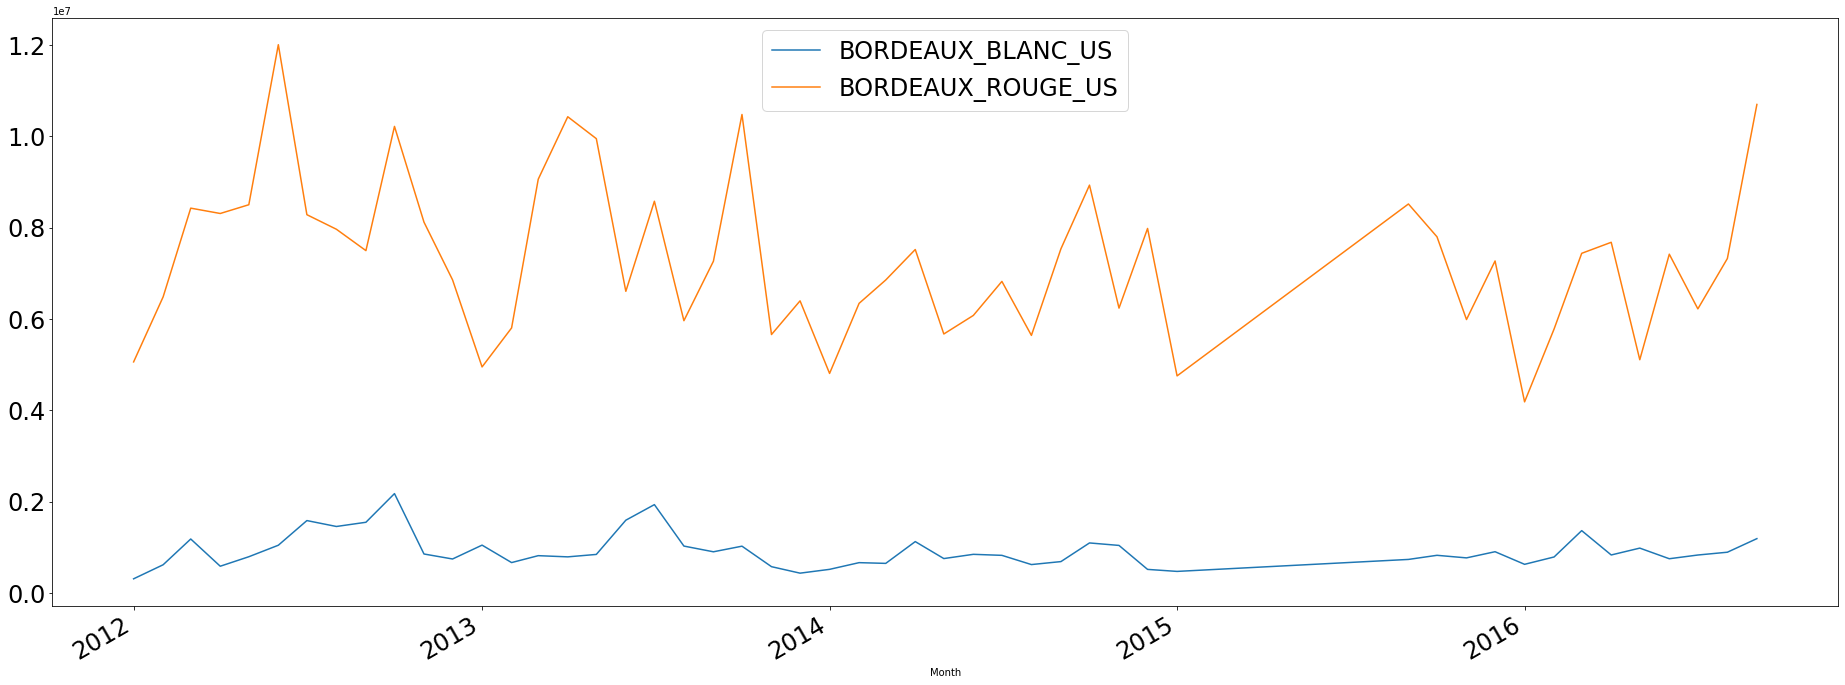

In [7]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_US'],
                                    fontsize = 24,
                                    figsize=(32 , 12)).legend(loc='best', fontsize=24)

In [8]:
CN_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_CN') ]
French_Wine_Export_in_Euros_DF[CN_columns].describe()


,ALSACE_BLANC_CN,BEAUJOLAIS_ROUGE_CN,BORDEAUX_BLANC_CN,BORDEAUX_ROUGE_CN,BOURGOGNE_BLANC_CN,BOURGOGNE_ROUGE_CN,CHAMPAGNE_MOUSSEUX_CN,EUROPE_ROUGE_CN,FRANCE_BLANC_CN,FRANCE_MOUSSEUX_CN,FRANCE_ROUGE_CN,LANGUEDOC_ROUGE_CN,LOIRE_BLANC_CN,LOIRE_ROUGE_CN,OTHER_ROUGE_CN,RHÔNE_ROUGE_CN
count,50.000000,50.00000,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01
mean,119348.360000,130292.47000,4.993186e+05,1.138432e+07,242575.340000,7.436432e+05,6.225160e+05,8.313372e+05,12978.062000,93298.256667,11185.281403,1.304245e+06,48771.330000,92016.740000,52969.948000,7.498312e+05
std,65116.609016,102214.45714,2.936971e+05,3.081051e+06,99492.736867,4.176045e+05,3.812781e+05,2.337996e+05,24705.479992,63521.773261,13888.069451,6.352887e+05,27922.200988,54704.609614,36129.014739,3.592653e+05
min,19546.000000,5833.00000,1.678740e+05,5.377235e+06,75396.000000,2.725460e+05,1.976760e+05,3.270090e+05,0.000000,20488.500000,260.500000,4.916860e+05,16643.500000,15325.000000,6337.750000,1.888270e+05
25%,82278.500000,66206.50000,3.117738e+05,9.737536e+06,171633.250000,4.214805e+05,3.897600e+05,6.529608e+05,1607.250000,46355.750000,4759.017857,9.207640e+05,31191.250000,54588.250000,28779.650000,5.089532e+05
50%,98656.000000,98427.50000,4.148980e+05,1.039686e+07,237099.500000,6.060540e+05,5.299100e+05,8.078685e+05,6237.750000,82644.583333,8837.333333,1.211934e+06,37845.750000,77491.500000,44118.875000,7.065070e+05
75%,161694.000000,158673.75000,5.623658e+05,1.316721e+07,308119.750000,9.648268e+05,7.029695e+05,9.859902e+05,14842.000000,118693.250000,12869.584821,1.416010e+06,62140.375000,119915.500000,62176.000000,9.285735e+05
max,317661.000000,453985.00000,1.890312e+06,1.905088e+07,535157.000000,2.021852e+06,2.103130e+06,1.367882e+06,163701.000000,366064.500000,96564.222222,3.607517e+06,151128.000000,272948.000000,179114.750000,1.755449e+06


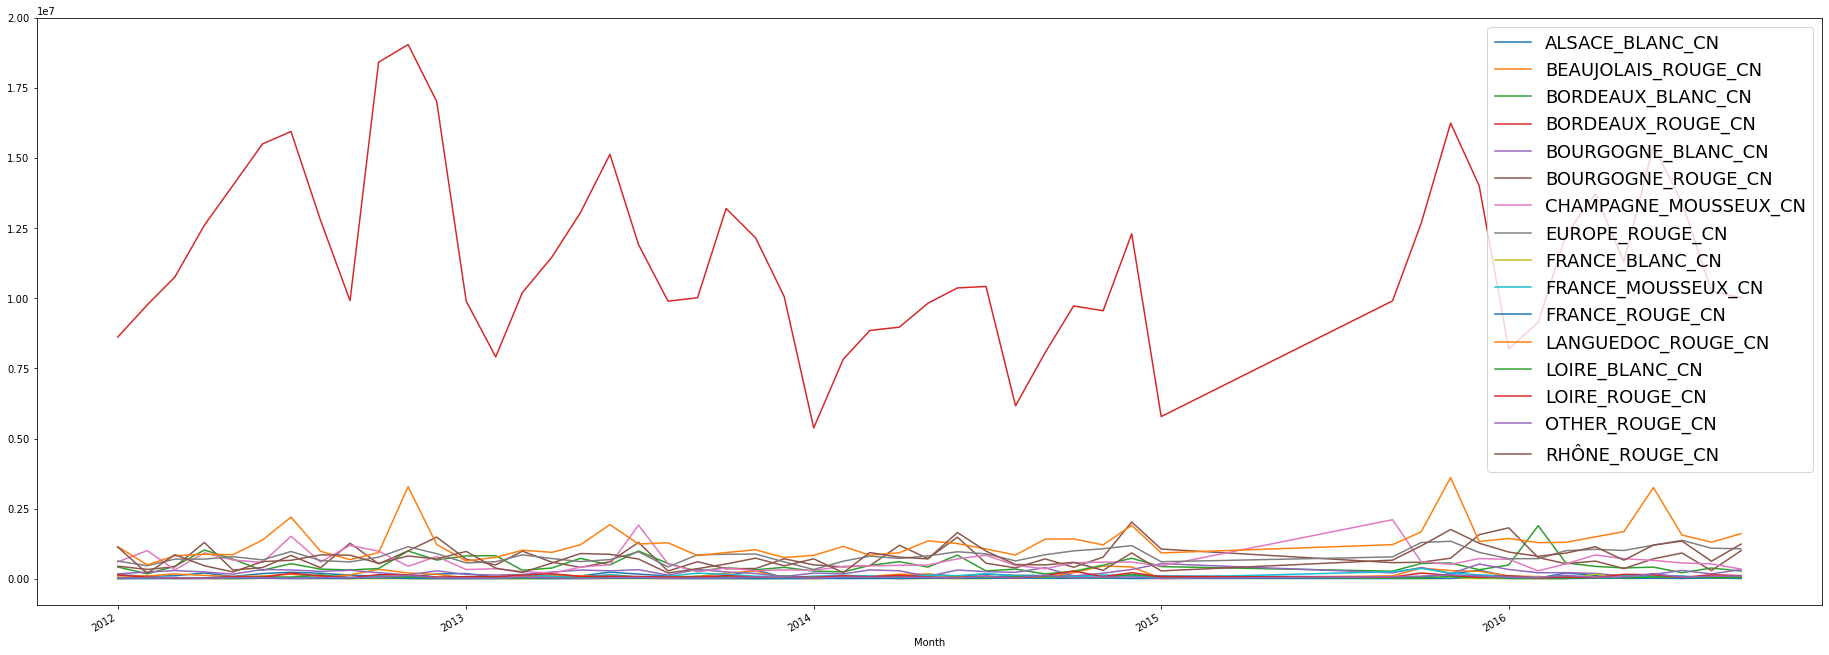

In [9]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    CN_columns,
                                   figsize=(32 , 12)).legend(fontsize=18)

In [10]:
Wines = "ALSACE BEAUJOLAIS BORDEAUX BOURGOGNE CHAMPAGNE EUROPE FRANCE LANGUEDOC LOIRE OTHER RHÔNE".split();
Variants = ['BLANC' , 'MOUSSEUX' , 'ROUGE'];
Countries = ['GB', 'US', 'DE', 'BE', 'CN', 'JP', 'CH', 'HK', 'NL', 'CA' , 'OTHER']



In [11]:
# A lot of possibilities , but only 176 are available ;)
len(Wines) * len(Variants) * len(Countries) 

363

In [12]:
from IPython.display import display


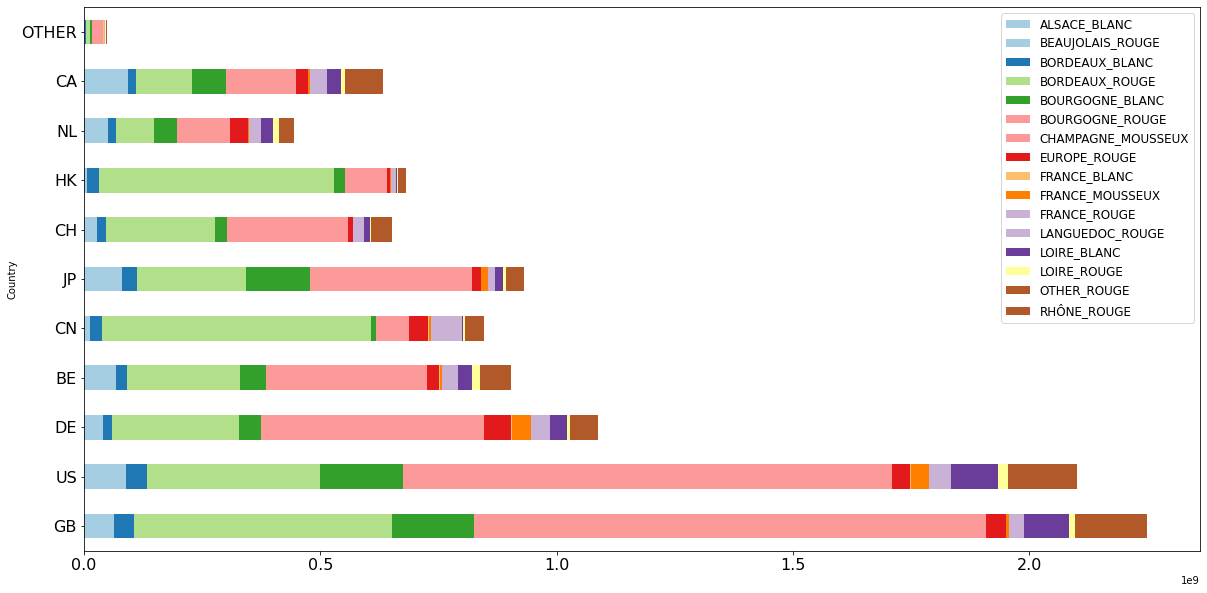

In [13]:
rows = [];
cols = []
for cntry in Countries:
    cntry_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_' + cntry) ]
    cols = []
    row = [cntry];
    for col in cntry_columns:
        col1 = col.replace('_' + cntry , "")
        sum1 = French_Wine_Export_in_Euros_DF[col].sum()
        row.append(sum1);
        cols.append(col1);
    rows.append(row);

plot_df = pd.DataFrame(rows , columns=['Country'] + cols);

    
plot_df.set_index('Country').plot.barh(stacked=True, figsize=(20,10), fontsize = 16, colormap='Paired').legend(loc='best', fontsize=12)

## Grouping Definition


Here, we start by defining as hierarchical model to forecast wine export by forecasting country and wine type and variant exports.

A wine type export is computed by aggregating (grouping) all variants exported to all countries.

In this section, we describe the definition of the grouping.
Again, for clarity, we restrict our work to some countries and some wine types and variants.


In [14]:

Regions = ['EUROPE', 'AMERICA', 'EUROPE' , 'EUROPE' , 'ASIA' , 'ASIA' , 'EUROPE',  'ASIA', 'EUROPE' , 'AMERICA' , 'OTHER_REGION']
lDict = dict(zip(Countries , Regions));

# simplify !!!!
Variants = ['BLANC' , 'ROUGE'];
Wines = Wines[0:3];
Countries = Countries[0:5]

In [15]:
# Grouping definition
lGroups = {}
lGroups["Country"] = Countries
lGroups["Variant"] = Variants
lGroups["Wine"] = Wines

lHierarchy = {};
lHierarchy['Levels'] = None;
lHierarchy['Data'] = None;
lHierarchy['Groups']= lGroups;
# the most important !!!!
lHierarchy['GroupOrder']= ["Wine", "Variant", "Country"]; # group by Wine first, then by variant, etc
lHierarchy['Type'] = "Grouped";
    


We want here to group first by Wine, then by variant and by country. The hierarchy is automatically created based on available columns. 

The hierarchy has been specified this way :

In [16]:
lHierarchy

{'Levels': None,
 'Data': None,
 'Groups': {'Country': ['GB', 'US', 'DE', 'BE', 'CN'],
  'Variant': ['BLANC', 'ROUGE'],
  'Wine': ['ALSACE', 'BEAUJOLAIS', 'BORDEAUX']},
 'GroupOrder': ['Wine', 'Variant', 'Country'],
 'Type': 'Grouped'}


Column names are of the type "w_v_c" where w is the wine type, v is the variant and c is the country (in the group order). A different group order leads to a differnet hierarchy and differnet models. The group order has a significant business semantics. 

When aggregated , a group name is emptied :
   * **"_BLANC_BE"** is the aggreagtion of all wine types of variant 'BLANC' that are exported to the country 'BE' and
   * **"__CN"** is the aggreagtion of all wine types of all variants that are exported to the country 'CN' (all what China can drink !!!)
   
All these generated names are not always available in our original training dataset (or even in nature, some wine types and variants are not compatible ;). 

The user may also need to adapt the training dataset column names to match the names defined by the automatic grouping (The name 'BORDEAUX_BLANC_DE' reflects a specific group order).

We plot the hierarchy ...


INFO:pyaf.timing:('OPERATION_START', 'HIERARCHICAL_PLOTTING')


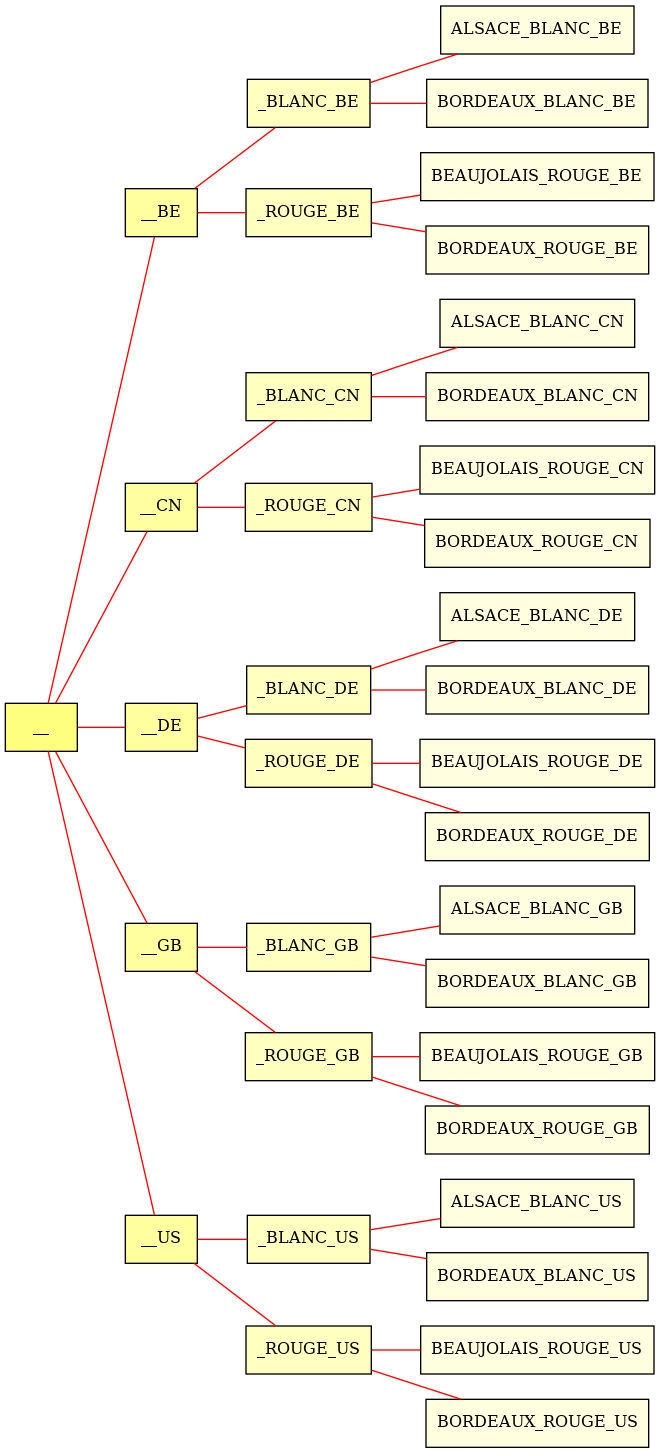

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.292, 'HIERARCHICAL_PLOTTING')


In [17]:
# create a model to plot the hierarchy.
import pyaf.HierarchicalForecastEngine as hautof
lEngine = hautof.cHierarchicalForecastEngine()


lSignalHierarchy = lEngine.plot_Hierarchy(French_Wine_Export_in_Euros_DF , "Month", "Signal", 1, 
                                          lHierarchy, None);

The strcuture levels have been built :

In [18]:
lSignalHierarchy.mStructure

{0: {'ALSACE_BLANC_BE': [],
  'ALSACE_BLANC_CN': [],
  'ALSACE_BLANC_DE': [],
  'ALSACE_BLANC_GB': [],
  'ALSACE_BLANC_US': [],
  'BEAUJOLAIS_ROUGE_BE': [],
  'BEAUJOLAIS_ROUGE_CN': [],
  'BEAUJOLAIS_ROUGE_DE': [],
  'BEAUJOLAIS_ROUGE_GB': [],
  'BEAUJOLAIS_ROUGE_US': [],
  'BORDEAUX_BLANC_BE': [],
  'BORDEAUX_BLANC_CN': [],
  'BORDEAUX_BLANC_DE': [],
  'BORDEAUX_BLANC_GB': [],
  'BORDEAUX_BLANC_US': [],
  'BORDEAUX_ROUGE_BE': [],
  'BORDEAUX_ROUGE_CN': [],
  'BORDEAUX_ROUGE_DE': [],
  'BORDEAUX_ROUGE_GB': [],
  'BORDEAUX_ROUGE_US': []},
 1: {'_BLANC_BE': ['ALSACE_BLANC_BE', 'BORDEAUX_BLANC_BE'],
  '_BLANC_CN': ['ALSACE_BLANC_CN', 'BORDEAUX_BLANC_CN'],
  '_BLANC_DE': ['ALSACE_BLANC_DE', 'BORDEAUX_BLANC_DE'],
  '_BLANC_GB': ['ALSACE_BLANC_GB', 'BORDEAUX_BLANC_GB'],
  '_BLANC_US': ['ALSACE_BLANC_US', 'BORDEAUX_BLANC_US'],
  '_ROUGE_BE': ['BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_BE'],
  '_ROUGE_CN': ['BEAUJOLAIS_ROUGE_CN', 'BORDEAUX_ROUGE_CN'],
  '_ROUGE_DE': ['BEAUJOLAIS_ROUGE_DE', 'BORDEA

## Hierarchical Modelling

Here, we build a first model on the previous hierarchy. Thsi will build an internal model for each node of the previous graph.

Note that the lower (most detailed) level data are coming from the datset and higher levels are obtained by aggregating previous levels.  

We discard the last 4 months of the dataset and try to forecast their values. 

In [19]:
# create a hierarchical model and train it
import pyaf.HierarchicalForecastEngine as hautof

lEngine = hautof.cHierarchicalForecastEngine()

lSignalVar = "Sales";

#
N = French_Wine_Export_in_Euros_DF.shape[0];
H = 4;
train_df = French_Wine_Export_in_Euros_DF.head(N-H);


lSignalHierarchy = lEngine.train(train_df , lDateColumn, lSignalVar, 1, lHierarchy, None);

INFO:pyaf.timing:('OPERATION_START', 'HIERARCHICAL_TRAINING')
INFO:pyaf.timing:('OPERATION_START', ('SIGNAL_TRAINING', {'Signals': ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'], 'Transformations': [('ALSACE_BLANC_BE', 'None', '_', 'T+S+R'), ('ALSACE_BLANC_BE', 'None', 'Diff_', 'T+S+R'), ('ALSACE_BLANC_BE', 'None', 'RelDiff_', 'T+S+R'), ('ALSACE_BLANC_BE', 'None', 'CumSum_', 'T+S+R'), ('ALSACE_BLANC_CN', 'None', '_', 'T+S+R'), ('ALSACE_BLANC_CN',

/home/antoine/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/antoine/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: -VERSION- is an invalid version and will not be supported in a future release
  warnings.warn(
/home/antoine/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/antoine/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/antoine/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: -VERSION- is an invalid version and will

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.52, ('TRAINING', {'Signal': 'ALSACE_BLANC_US', 'Transformation': 'Diff_ALSACE_BLANC_US'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BEAUJOLAIS_ROUGE_CN', 'Transformation': 'Diff_BEAUJOLAIS_ROUGE_CN'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.504, ('TRAINING', {'Signal': 'BEAUJOLAIS_ROUGE_BE', 'Transformation': '_BEAUJOLAIS_ROUGE_BE'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BEAUJOLAIS_ROUGE_CN', 'Transformation': 'RelDiff_BEAUJOLAIS_ROUGE_CN'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.657, ('TRAINING', {'Signal': 'ALSACE_BLANC_US', 'Transformation': 'RelDiff_ALSACE_BLANC_US'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BEAUJOLAIS_ROUGE_CN', 'Transformation': 'CumSum_BEAUJOLAIS_ROUGE_CN'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.692, ('TRAINING', {'Signal': 'ALSACE_BLANC_US', 'Transformation': 'CumSum_ALSACE_BLANC_US'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAI

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.507, ('TRAINING', {'Signal': 'BORDEAUX_BLANC_DE', 'Transformation': '_BORDEAUX_BLANC_DE'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BORDEAUX_BLANC_GB', 'Transformation': 'CumSum_BORDEAUX_BLANC_GB'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.713, ('TRAINING', {'Signal': 'BORDEAUX_BLANC_CN', 'Transformation': 'RelDiff_BORDEAUX_BLANC_CN'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BORDEAUX_BLANC_US', 'Transformation': '_BORDEAUX_BLANC_US'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.646, ('TRAINING', {'Signal': 'BORDEAUX_BLANC_DE', 'Transformation': 'Diff_BORDEAUX_BLANC_DE'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BORDEAUX_BLANC_US', 'Transformation': 'Diff_BORDEAUX_BLANC_US'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.475, ('TRAINING', {'Signal': 'BORDEAUX_BLANC_DE', 'Transformation': 'CumSum_BORDEAUX_BLANC_DE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.465, ('T

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.504, ('TRAINING', {'Signal': 'BORDEAUX_ROUGE_US', 'Transformation': 'CumSum_BORDEAUX_ROUGE_US'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '_BLANC_CN', 'Transformation': 'RelDiff__BLANC_CN'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.523, ('TRAINING', {'Signal': '_BLANC_BE', 'Transformation': '__BLANC_BE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.591, ('TRAINING', {'Signal': 'BORDEAUX_ROUGE_US', 'Transformation': 'RelDiff_BORDEAUX_ROUGE_US'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '_BLANC_CN', 'Transformation': 'CumSum__BLANC_CN'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.483, ('TRAINING', {'Signal': '_BLANC_BE', 'Transformation': 'Diff__BLANC_BE'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '_BLANC_DE', 'Transformation': 'Diff__BLANC_DE'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '_BLANC_DE', 'Transformation': '__BLANC_DE'}))
INFO:pyaf.timing:(

INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '__BE', 'Transformation': '___BE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.502, ('TRAINING', {'Signal': '_ROUGE_GB', 'Transformation': 'Diff__ROUGE_GB'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '__BE', 'Transformation': 'Diff___BE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.485, ('TRAINING', {'Signal': '_ROUGE_GB', 'Transformation': 'CumSum__ROUGE_GB'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.464, ('TRAINING', {'Signal': '_ROUGE_US', 'Transformation': '__ROUGE_US'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '__BE', 'Transformation': 'RelDiff___BE'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '__BE', 'Transformation': 'CumSum___BE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.585, ('TRAINING', {'Signal': '_ROUGE_GB', 'Transformation': 'RelDiff__ROUGE_GB'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '__CN', 'Transformation': '__

INFO:pyaf.timing:('OPERATION_START', ('FINALIZE_TRAINING', {'Signals': ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'], 'Transformations': [('ALSACE_BLANC_BE', [('ALSACE_BLANC_BE', 'None', 'CumSum_', 'T+S+R'), ('ALSACE_BLANC_BE', 'None', 'Diff_', 'T+S+R'), ('ALSACE_BLANC_BE', 'None', 'RelDiff_', 'T+S+R'), ('ALSACE_BLANC_BE', 'None', '_', 'T+S+R')]), ('ALSACE_BLANC_CN', [('ALSACE_BLANC_CN', 'None', 'CumSum_', 'T+S+R'), ('ALSACE_BLANC_CN', 'None', '

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.015, ('MODEL_SELECTION', {'Signal': 'ALSACE_BLANC_BE', 'Transformations': [('ALSACE_BLANC_BE', 'None', 'CumSum_', 'T+S+R'), ('ALSACE_BLANC_BE', 'None', 'Diff_', 'T+S+R'), ('ALSACE_BLANC_BE', 'None', 'RelDiff_', 'T+S+R'), ('ALSACE_BLANC_BE', 'None', '_', 'T+S+R')]}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'ALSACE_BLANC_BE', 'Model': '_ALSACE_BLANC_BE_ConstantTrend_residue_bestCycle_byMAPE_residue_NoAR'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.029, ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'ALSACE_BLANC_BE', 'Model': '_ALSACE_BLANC_BE_ConstantTrend_residue_bestCycle_byMAPE_residue_NoAR'}))
INFO:pyaf.timing:('OPERATION_START', ('COMPUTE_PREDICTION_INTERVALS', {'Signal': 'ALSACE_BLANC_BE'}))
INFO:pyaf.timing:('OPERATION_START', ('MODEL_SELECTION', {'Signal': 'ALSACE_BLANC_CN', 'Transformations': [('ALSACE_BLANC_CN', 'None', 'CumSum_', 'T+S+R'), ('ALSACE_BLANC_CN', 'None', 'Diff_', 'T+S+R'), ('ALSACE_BLANC

INFO:pyaf.timing:('OPERATION_START', ('MODEL_SELECTION', {'Signal': 'BEAUJOLAIS_ROUGE_DE', 'Transformations': [('BEAUJOLAIS_ROUGE_DE', 'None', 'CumSum_', 'T+S+R'), ('BEAUJOLAIS_ROUGE_DE', 'None', 'Diff_', 'T+S+R'), ('BEAUJOLAIS_ROUGE_DE', 'None', 'RelDiff_', 'T+S+R'), ('BEAUJOLAIS_ROUGE_DE', 'None', '_', 'T+S+R')]}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.012, ('MODEL_SELECTION', {'Signal': 'BEAUJOLAIS_ROUGE_DE', 'Transformations': [('BEAUJOLAIS_ROUGE_DE', 'None', 'CumSum_', 'T+S+R'), ('BEAUJOLAIS_ROUGE_DE', 'None', 'Diff_', 'T+S+R'), ('BEAUJOLAIS_ROUGE_DE', 'None', 'RelDiff_', 'T+S+R'), ('BEAUJOLAIS_ROUGE_DE', 'None', '_', 'T+S+R')]}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'BEAUJOLAIS_ROUGE_DE', 'Model': 'Diff_BEAUJOLAIS_ROUGE_DE_ConstantTrend_residue_bestCycle_byMAPE_residue_NoAR'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.033, ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'BEAUJOLAIS_ROUGE_DE', 'Model': 'Diff_BEAUJOLAIS_ROUGE_DE_ConstantTren

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.033, ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'BORDEAUX_BLANC_GB', 'Model': 'Diff_BORDEAUX_BLANC_GB_ConstantTrend_residue_bestCycle_byMAPE_residue_AR(11)'}))
INFO:pyaf.timing:('OPERATION_START', ('COMPUTE_PREDICTION_INTERVALS', {'Signal': 'BORDEAUX_BLANC_GB'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.039, ('COMPUTE_PREDICTION_INTERVALS', {'Signal': 'BORDEAUX_BLANC_GB'}))
INFO:pyaf.timing:('OPERATION_START', ('MODEL_SELECTION', {'Signal': 'BORDEAUX_BLANC_US', 'Transformations': [('BORDEAUX_BLANC_US', 'None', 'CumSum_', 'T+S+R'), ('BORDEAUX_BLANC_US', 'None', 'Diff_', 'T+S+R'), ('BORDEAUX_BLANC_US', 'None', 'RelDiff_', 'T+S+R'), ('BORDEAUX_BLANC_US', 'None', '_', 'T+S+R')]}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.008, ('MODEL_SELECTION', {'Signal': 'BORDEAUX_BLANC_US', 'Transformations': [('BORDEAUX_BLANC_US', 'None', 'CumSum_', 'T+S+R'), ('BORDEAUX_BLANC_US', 'None', 'Diff_', 'T+S+R'), ('BORDEAUX_BLANC_US', 'None', 'RelDiff_', 'T+S+

INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': '_BLANC_BE', 'Model': '__BLANC_BE_Lag1Trend_residue_bestCycle_byMAPE_residue_AR(11)'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.036, ('COMPUTE_PREDICTION_INTERVALS', {'Signal': 'BORDEAUX_ROUGE_US'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.032, ('UPDATE_BEST_MODEL_PERFS', {'Signal': '_BLANC_BE', 'Model': '__BLANC_BE_Lag1Trend_residue_bestCycle_byMAPE_residue_AR(11)'}))
INFO:pyaf.timing:('OPERATION_START', ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '_BLANC_BE'}))
INFO:pyaf.timing:('OPERATION_START', ('MODEL_SELECTION', {'Signal': '_BLANC_CN', 'Transformations': [('_BLANC_CN', 'None', 'CumSum_', 'T+S+R'), ('_BLANC_CN', 'None', 'Diff_', 'T+S+R'), ('_BLANC_CN', 'None', 'RelDiff_', 'T+S+R'), ('_BLANC_CN', 'None', '_', 'T+S+R')]}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.031, ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '_BLANC_BE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.012, ('MODEL_SELECTION'

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.032, ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '_ROUGE_DE'}))
INFO:pyaf.timing:('OPERATION_START', ('MODEL_SELECTION', {'Signal': '_ROUGE_GB', 'Transformations': [('_ROUGE_GB', 'None', 'CumSum_', 'T+S+R'), ('_ROUGE_GB', 'None', 'Diff_', 'T+S+R'), ('_ROUGE_GB', 'None', 'RelDiff_', 'T+S+R'), ('_ROUGE_GB', 'None', '_', 'T+S+R')]}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.008, ('MODEL_SELECTION', {'Signal': '_ROUGE_GB', 'Transformations': [('_ROUGE_GB', 'None', 'CumSum_', 'T+S+R'), ('_ROUGE_GB', 'None', 'Diff_', 'T+S+R'), ('_ROUGE_GB', 'None', 'RelDiff_', 'T+S+R'), ('_ROUGE_GB', 'None', '_', 'T+S+R')]}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': '_ROUGE_GB', 'Model': '__ROUGE_GB_Lag1Trend_residue_bestCycle_byMAPE_residue_NoAR'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.028, ('UPDATE_BEST_MODEL_PERFS', {'Signal': '_ROUGE_GB', 'Model': '__ROUGE_GB_Lag1Trend_residue_bestCycle_byMAPE_residue_NoAR'}))
INF

INFO:pyaf.timing:('OPERATION_START', ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '__'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.027, ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '__'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 6.026, ('FINALIZE_TRAINING', {'Signals': ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'], 'Transformations': [('ALSACE_BLANC_BE', [('ALSACE_BLANC_BE', 'None', 'CumSum_', 'T+S+R'), ('ALSACE_BLANC_BE', 'None', 'Diff_', 

/usr/lib/python3/dist-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Month_Normalized_x', 'row_number_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(
/usr/lib/python3/dist-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Month_Normalized_x', 'Month_Normalized_^3_x', 'row_number_x', 'Month_Normalized_^2_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 4.966, ('FORECASTING', {'Signals': ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDE

INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_VALID_PERF {'Signal': 'BEAUJOLAIS_ROUGE_DE_BU_Forecast', 'Length': 9, 'MAPE': 0.6144, 'RMSE': 155871.73582628762, 'MAE': 101230.22222222222, 'SMAPE': 0.6012, 'ErrorMean': -55130.88888888889, 'ErrorStdDev': 145796.375537326, 'R2': -0.1492885450742618, 'Pearson': 0.0, 'MedAE': 42501.5, 'LnQ': 5.692548113948143}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_FIT_PERF {'Signal': 'BEAUJOLAIS_ROUGE_GB_BU_Forecast', 'Length': 36, 'MAPE': 0.7102, 'RMSE': 568068.8334224873, 'MAE': 414434.76689684176, 'SMAPE': 0.4846, 'ErrorMean': 9927.16628304145, 'ErrorStdDev': 567982.0867558891, 'R2': -0.6146056831972657, 'Pearson': 0.17032695714559062, 'MedAE': 298896.99999999965, 'LnQ': 17.827099910240765}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_VALID_PERF {'Signal': 'BEAUJOLAIS_ROUGE_GB_BU_Forecast', 'Length': 9, 'MAPE': 0.3365, 'RMSE': 484042.82390307094, 'MAE': 327908.4444444452, 'SMAPE': 0.3646, 'ErrorMean': -74518.93394713191, 'ErrorStdDev': 4

INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_FIT_PERF {'Signal': 'BORDEAUX_ROUGE_US_BU_Forecast', 'Length': 36, 'MAPE': 0.1584, 'RMSE': 1471850.6026004446, 'MAE': 1161093.0378946168, 'SMAPE': 0.154, 'ErrorMean': 0.0, 'ErrorStdDev': 1471850.6026004446, 'R2': 0.2595421691639791, 'Pearson': 0.5257410910524861, 'MedAE': 985239.0831511058, 'LnQ': 1.3321995797745096}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_VALID_PERF {'Signal': 'BORDEAUX_ROUGE_US_BU_Forecast', 'Length': 9, 'MAPE': 0.2095, 'RMSE': 1423096.364681896, 'MAE': 1234635.7322412622, 'SMAPE': 0.1938, 'ErrorMean': 13359.461174891538, 'ErrorStdDev': 1423033.656653259, 'R2': -0.027475821531138145, 'Pearson': 0.0, 'MedAE': 1027185.6522214338, 'LnQ': 0.4869588300300327}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_FIT_PERF {'Signal': '_BLANC_BE_BU_Forecast', 'Length': 36, 'MAPE': 0.2215, 'RMSE': 766218.6333087019, 'MAE': 380695.8865740741, 'SMAPE': 0.1945, 'ErrorMean': -106833.66898148147, 'ErrorStdDev': 758734.1834934093

INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_VALID_PERF {'Signal': '__BE_BU_Forecast', 'Length': 9, 'MAPE': 0.1677, 'RMSE': 1168437.013401952, 'MAE': 996528.7794292242, 'SMAPE': 0.1674, 'ErrorMean': -257601.42912931048, 'ErrorStdDev': 1139687.0438845085, 'R2': 0.3353065837842645, 'Pearson': 0.0, 'MedAE': 1019357.0152692255, 'LnQ': 0.34289572130136686}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_FIT_PERF {'Signal': '__CN_BU_Forecast', 'Length': 36, 'MAPE': 0.2936, 'RMSE': 4506653.669903202, 'MAE': 3639379.8762349472, 'SMAPE': 0.3208, 'ErrorMean': -1949452.904952881, 'ErrorStdDev': 4063195.869241695, 'R2': -0.8918415437230038, 'Pearson': -0.20757466149866335, 'MedAE': 3035784.682823318, 'LnQ': 5.3894789554488485}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_VALID_PERF {'Signal': '__CN_BU_Forecast', 'Length': 9, 'MAPE': 0.2216, 'RMSE': 2786297.681756093, 'MAE': 2102090.225422453, 'SMAPE': 0.1843, 'ErrorMean': 343913.0008483955, 'ErrorStdDev': 2764991.612863741, 'R2': 0.229568

In [20]:
French_Wine_Export_in_Euros_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 177 entries, Month to RHÔNE_ROUGE_US
dtypes: datetime64[ns](1), float64(56), int64(120)
memory usage: 69.3 KB


In [21]:
lInfo = lEngine.to_dict()
lInfo

{'Structure': {0: {'ALSACE_BLANC_BE': [],
   'ALSACE_BLANC_CN': [],
   'ALSACE_BLANC_DE': [],
   'ALSACE_BLANC_GB': [],
   'ALSACE_BLANC_US': [],
   'BEAUJOLAIS_ROUGE_BE': [],
   'BEAUJOLAIS_ROUGE_CN': [],
   'BEAUJOLAIS_ROUGE_DE': [],
   'BEAUJOLAIS_ROUGE_GB': [],
   'BEAUJOLAIS_ROUGE_US': [],
   'BORDEAUX_BLANC_BE': [],
   'BORDEAUX_BLANC_CN': [],
   'BORDEAUX_BLANC_DE': [],
   'BORDEAUX_BLANC_GB': [],
   'BORDEAUX_BLANC_US': [],
   'BORDEAUX_ROUGE_BE': [],
   'BORDEAUX_ROUGE_CN': [],
   'BORDEAUX_ROUGE_DE': [],
   'BORDEAUX_ROUGE_GB': [],
   'BORDEAUX_ROUGE_US': []},
  1: {'_BLANC_BE': ['ALSACE_BLANC_BE', 'BORDEAUX_BLANC_BE'],
   '_BLANC_CN': ['ALSACE_BLANC_CN', 'BORDEAUX_BLANC_CN'],
   '_BLANC_DE': ['ALSACE_BLANC_DE', 'BORDEAUX_BLANC_DE'],
   '_BLANC_GB': ['ALSACE_BLANC_GB', 'BORDEAUX_BLANC_GB'],
   '_BLANC_US': ['ALSACE_BLANC_US', 'BORDEAUX_BLANC_US'],
   '_ROUGE_BE': ['BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_BE'],
   '_ROUGE_CN': ['BEAUJOLAIS_ROUGE_CN', 'BORDEAUX_ROUGE_CN'],
   '_R

In [22]:
lInfo['Structure']

{0: {'ALSACE_BLANC_BE': [],
  'ALSACE_BLANC_CN': [],
  'ALSACE_BLANC_DE': [],
  'ALSACE_BLANC_GB': [],
  'ALSACE_BLANC_US': [],
  'BEAUJOLAIS_ROUGE_BE': [],
  'BEAUJOLAIS_ROUGE_CN': [],
  'BEAUJOLAIS_ROUGE_DE': [],
  'BEAUJOLAIS_ROUGE_GB': [],
  'BEAUJOLAIS_ROUGE_US': [],
  'BORDEAUX_BLANC_BE': [],
  'BORDEAUX_BLANC_CN': [],
  'BORDEAUX_BLANC_DE': [],
  'BORDEAUX_BLANC_GB': [],
  'BORDEAUX_BLANC_US': [],
  'BORDEAUX_ROUGE_BE': [],
  'BORDEAUX_ROUGE_CN': [],
  'BORDEAUX_ROUGE_DE': [],
  'BORDEAUX_ROUGE_GB': [],
  'BORDEAUX_ROUGE_US': []},
 1: {'_BLANC_BE': ['ALSACE_BLANC_BE', 'BORDEAUX_BLANC_BE'],
  '_BLANC_CN': ['ALSACE_BLANC_CN', 'BORDEAUX_BLANC_CN'],
  '_BLANC_DE': ['ALSACE_BLANC_DE', 'BORDEAUX_BLANC_DE'],
  '_BLANC_GB': ['ALSACE_BLANC_GB', 'BORDEAUX_BLANC_GB'],
  '_BLANC_US': ['ALSACE_BLANC_US', 'BORDEAUX_BLANC_US'],
  '_ROUGE_BE': ['BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_BE'],
  '_ROUGE_CN': ['BEAUJOLAIS_ROUGE_CN', 'BORDEAUX_ROUGE_CN'],
  '_ROUGE_DE': ['BEAUJOLAIS_ROUGE_DE', 'BORDEA

In [23]:
lInfo['Models'].keys()

dict_keys(['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'])

In [24]:
lInfo['Models']['BORDEAUX_ROUGE_CN']

{'Dataset': {'Time': {'TimeVariable': 'Month',
   'TimeMinMax': ['2012-01-01 00:00:00', '2016-05-01 00:00:00'],
   'Horizon': 1},
  'Signal': 'BORDEAUX_ROUGE_CN',
  'Training_Signal_Length': 46},
 'Model': {'Best_Decomposition': 'Diff_BORDEAUX_ROUGE_CN_ConstantTrend_residue_bestCycle_byMAPE_residue_AR(11)',
  'Signal_Decomposition_Type': 'T+S+R',
  'Signal_Transoformation': 'Difference',
  'Trend': 'ConstantTrend',
  'Cycle': 'Cycle_None',
  'AR_Model': 'AR'},
 'Model_Performance': {'MAPE': 0.2431,
  'MASE': 0.697,
  'CRPS': 414909.5477440574,
  'MAE': 2095071.2871508482,
  'RMSE': 2712945.66113926,
  'MedAE': 1591622.6505130827,
  'LnQ': 0.7337451269271154,
  'COMPLEXITY': 10.0}}

In [25]:
perfs = [];
for model in sorted(lInfo['Models'].keys()):
    lPerf = lInfo['Models'][model]['Model_Performance']
    perfs.append([model , lPerf['RMSE'] , lPerf['MAPE']])
df_perf = pd.DataFrame(perfs , columns=['Model' , 'RMSE' , 'MAPE']);
df_perf = df_perf.sort_values(by = ['MAPE'])
print(df_perf)

                  Model          RMSE    MAPE
23            _BLANC_GB  1.396166e+05  0.1098
13    BORDEAUX_BLANC_GB  8.861629e+04  0.1116
22            _BLANC_DE  1.416086e+05  0.1370
3       ALSACE_BLANC_GB  6.648017e+04  0.1402
34                 __GB  1.567222e+06  0.1579
30                   __  7.143604e+06  0.1582
18    BORDEAUX_ROUGE_GB  1.259435e+06  0.1592
28            _ROUGE_GB  1.442702e+06  0.1611
15    BORDEAUX_ROUGE_BE  8.702642e+05  0.1779
25            _ROUGE_BE  8.828202e+05  0.1808
31                 __BE  1.304601e+06  0.1846
2       ALSACE_BLANC_DE  1.447695e+05  0.1906
24            _BLANC_US  4.062902e+05  0.1927
29            _ROUGE_US  1.585113e+06  0.1928
14    BORDEAUX_BLANC_US  2.191494e+05  0.1983
35                 __US  2.012725e+06  0.2060
19    BORDEAUX_ROUGE_US  1.423096e+06  0.2095
33                 __DE  1.311702e+06  0.2377
4       ALSACE_BLANC_US  2.021724e+05  0.2382
32                 __CN  3.062225e+06  0.2397
27            _ROUGE_DE  1.118073e

INFO:pyaf.timing:('OPERATION_START', 'HIERARCHICAL_PLOTTING')


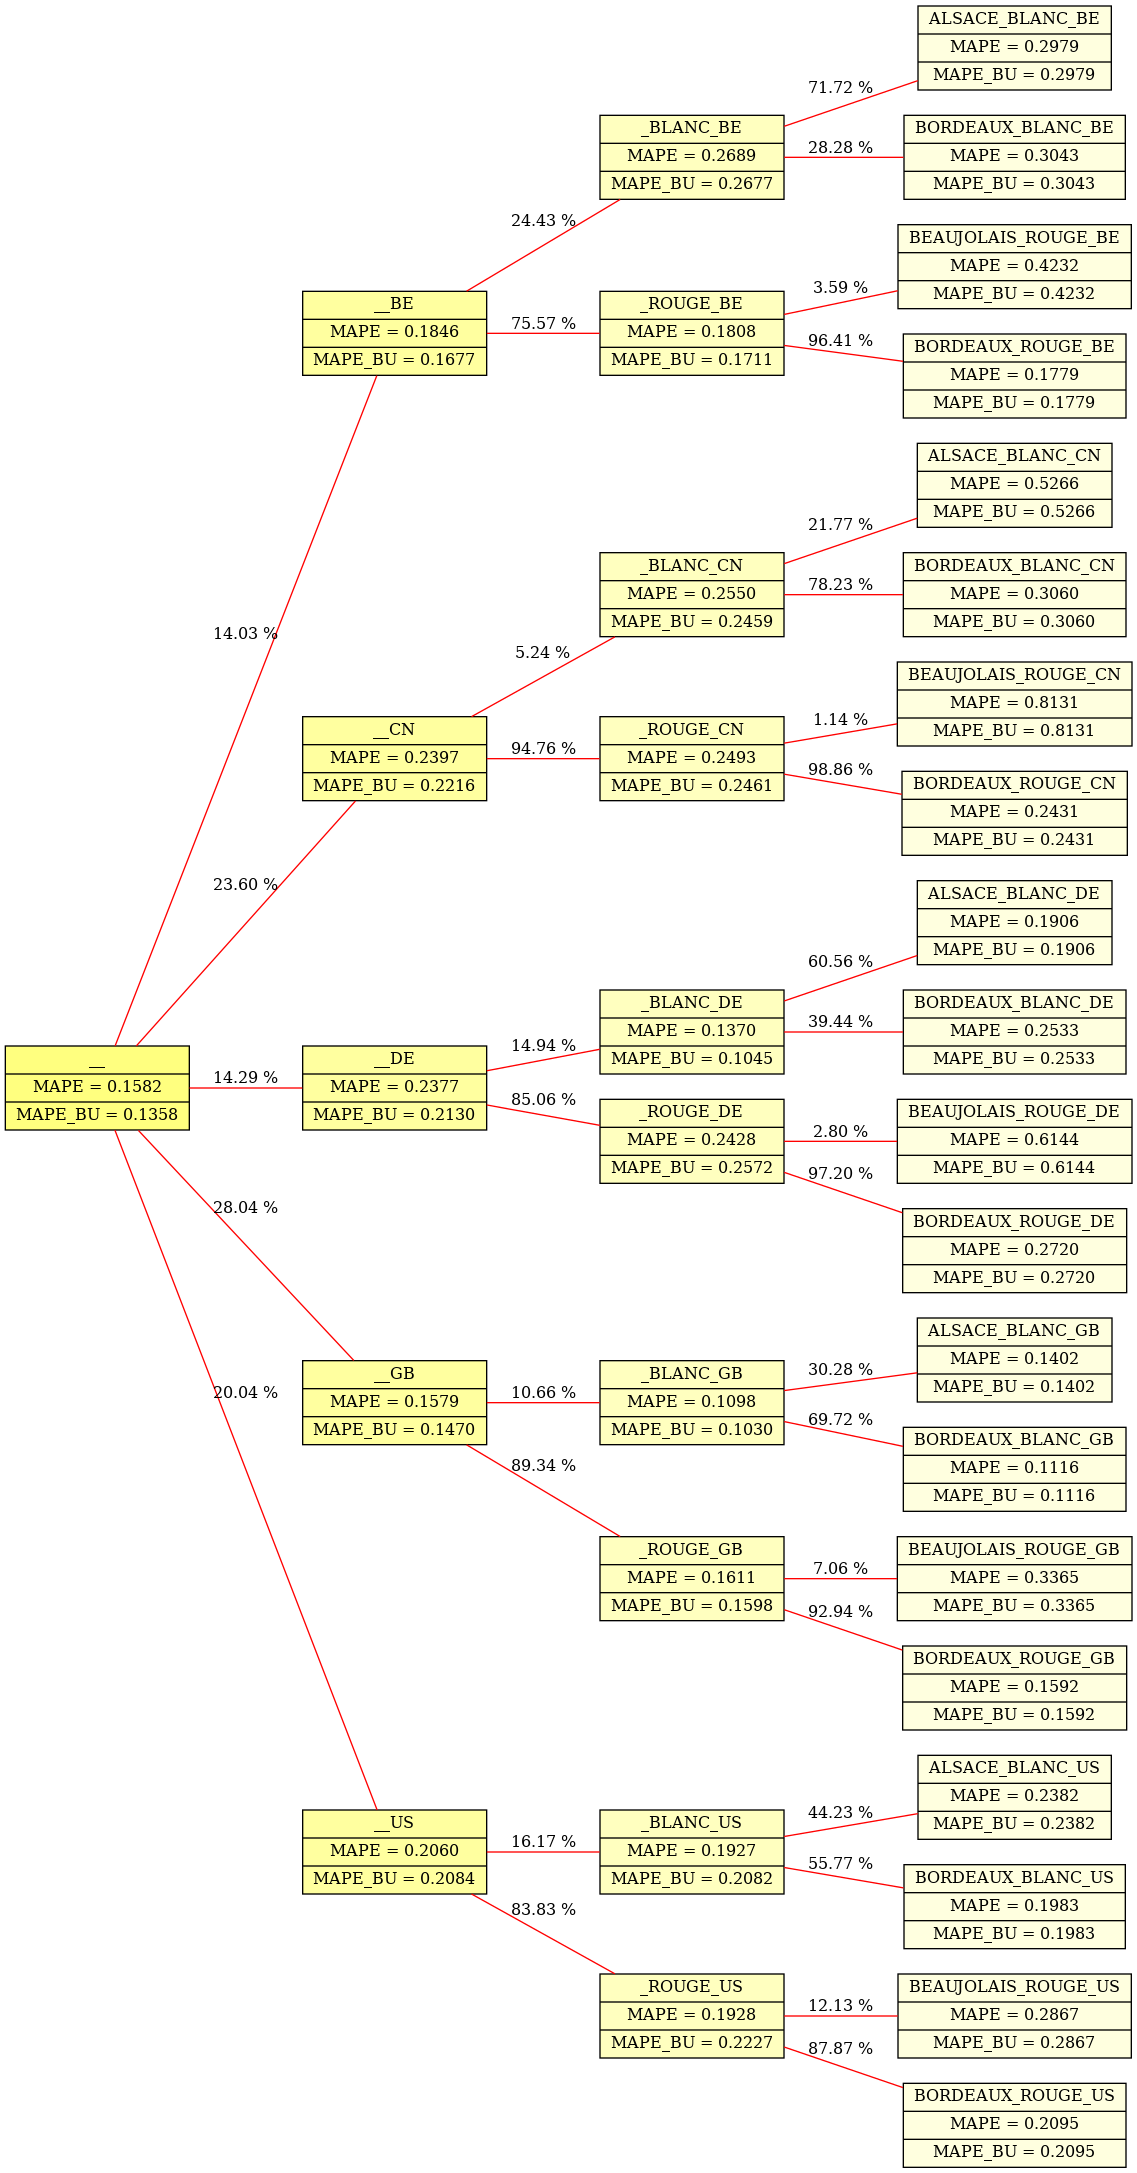

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.393, 'HIERARCHICAL_PLOTTING')


In [26]:
lEngine.mSignalHierarchy.plot()

In [27]:
CN_Model = lEngine.mSignalHierarchy.mModels.mSignalDecomposition.mBestModels['__CN'] # __CN is at hierarchical level 2

In [28]:
CN_Model.to_dict()

{'Dataset': {'Time': {'TimeVariable': 'Month',
   'TimeMinMax': ['2012-01-01 00:00:00', '2016-05-01 00:00:00'],
   'Horizon': 1},
  'Signal': '__CN',
  'Training_Signal_Length': 46},
 'Model': {'Best_Decomposition': '___CN_ConstantTrend_residue_bestCycle_byMAPE_residue_AR(11)',
  'Signal_Decomposition_Type': 'T+S+R',
  'Signal_Transoformation': 'NoTransf',
  'Trend': 'ConstantTrend',
  'Cycle': 'Cycle_None',
  'AR_Model': 'AR'},
 'Model_Performance': {'MAPE': 0.2397,
  'MASE': 0.7447,
  'CRPS': 517552.9247040513,
  'MAE': 2310954.5925318357,
  'RMSE': 3062224.840716141,
  'MedAE': 1174093.7836004645,
  'LnQ': 0.7566924200539923,
  'COMPLEXITY': 9.0}}

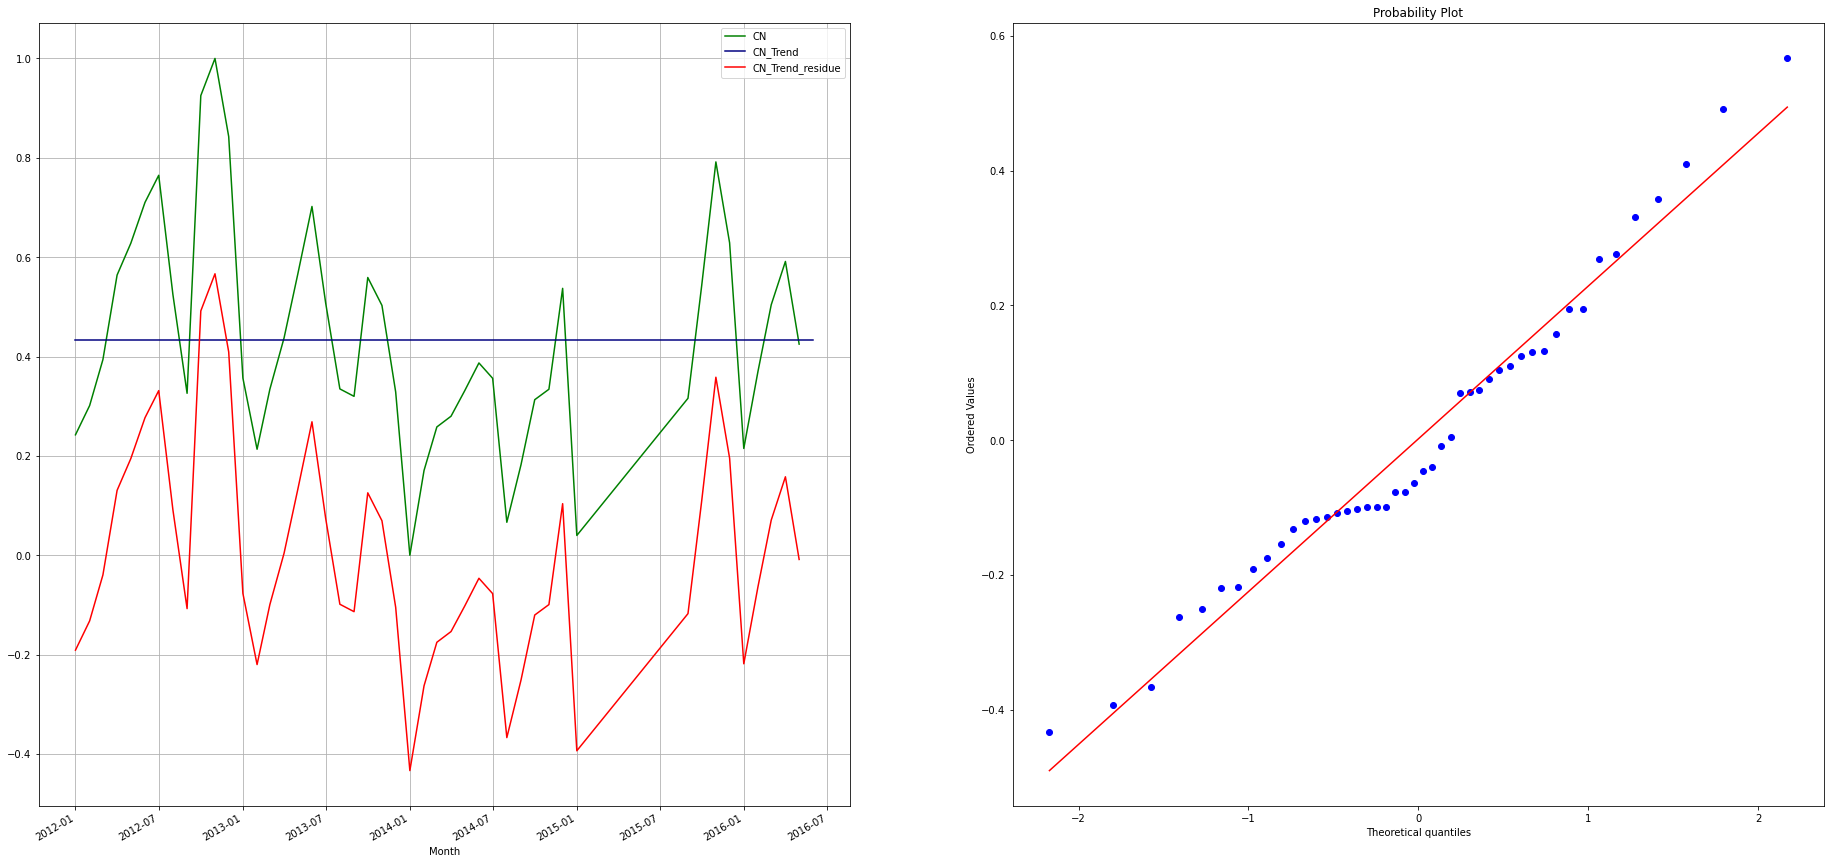

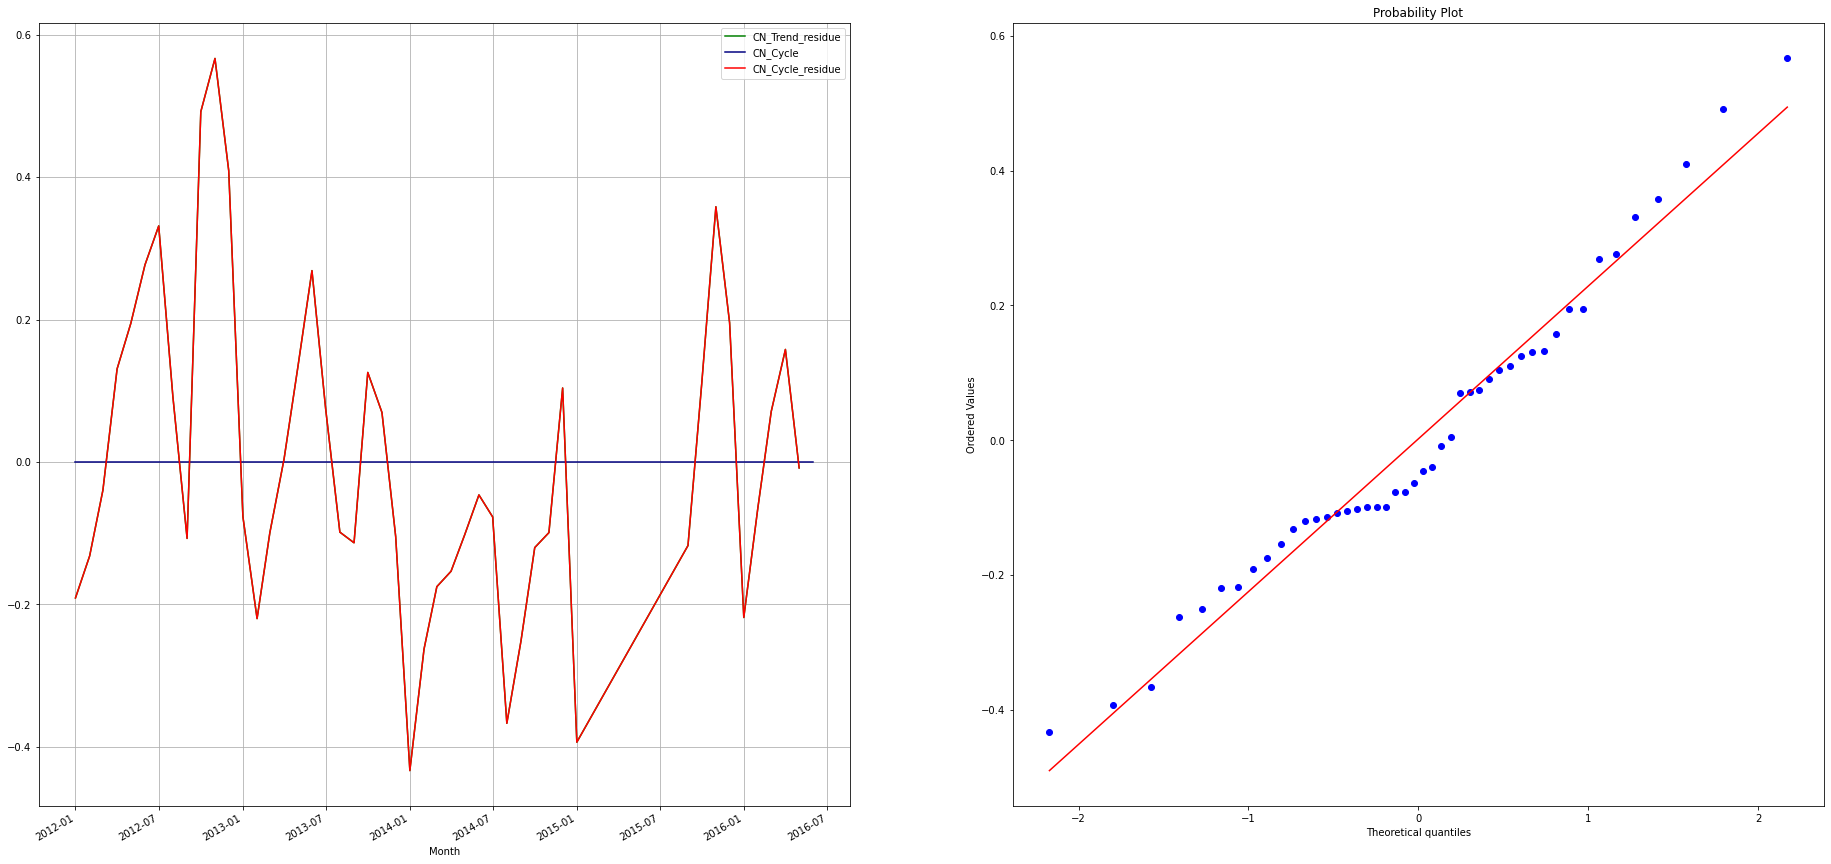

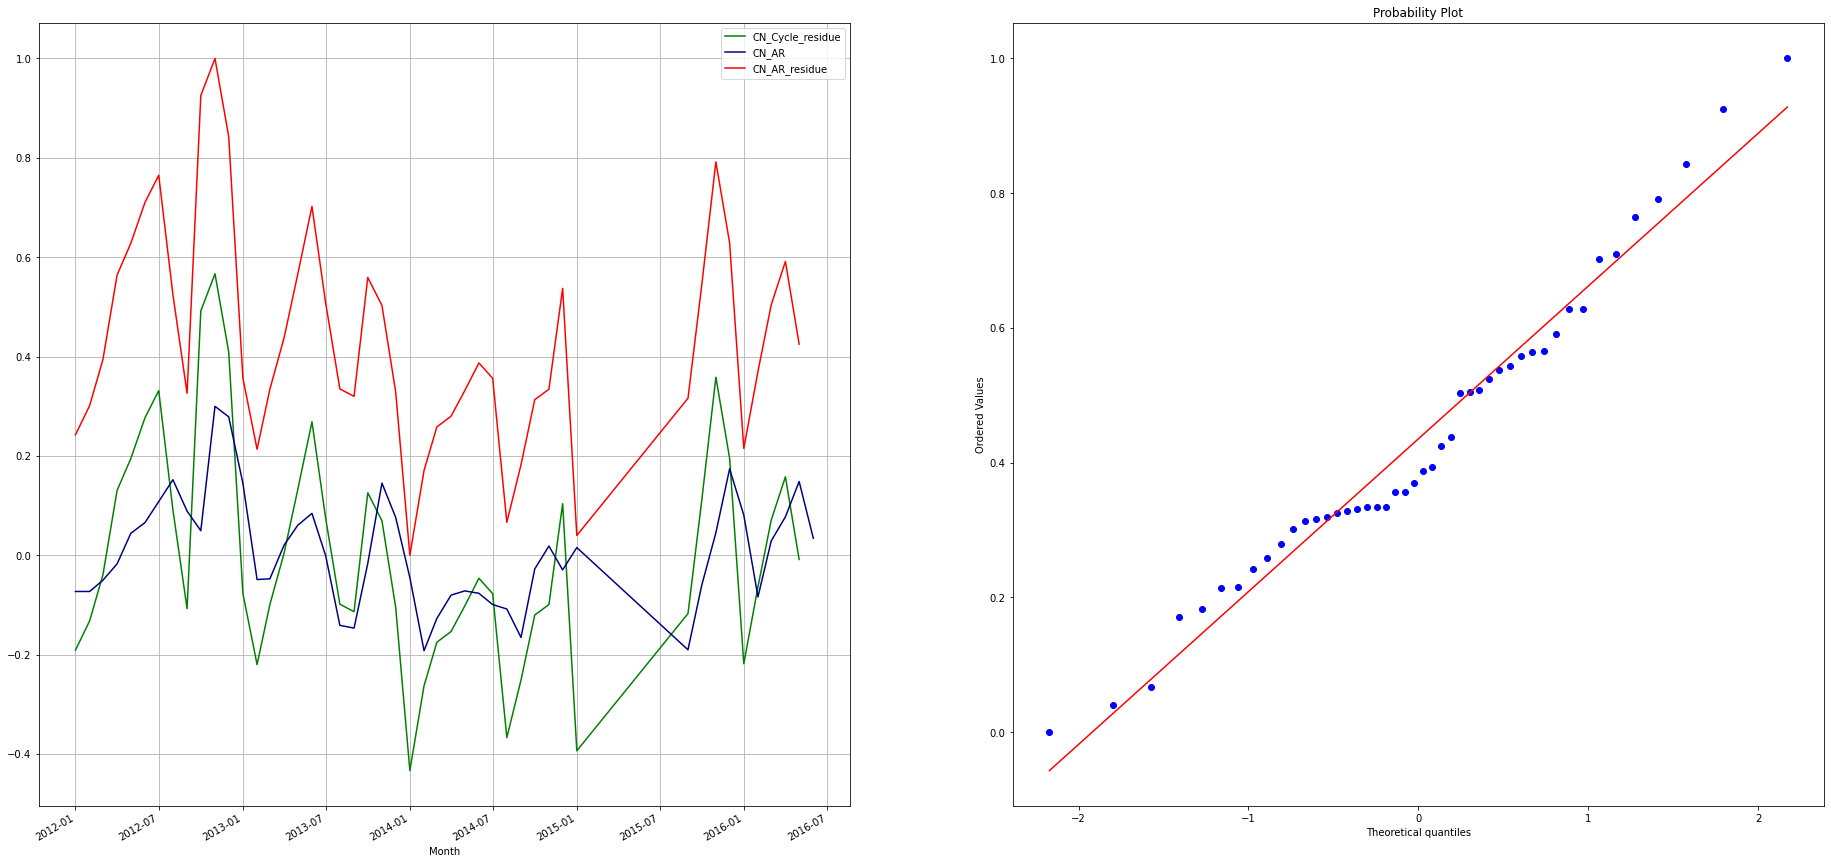

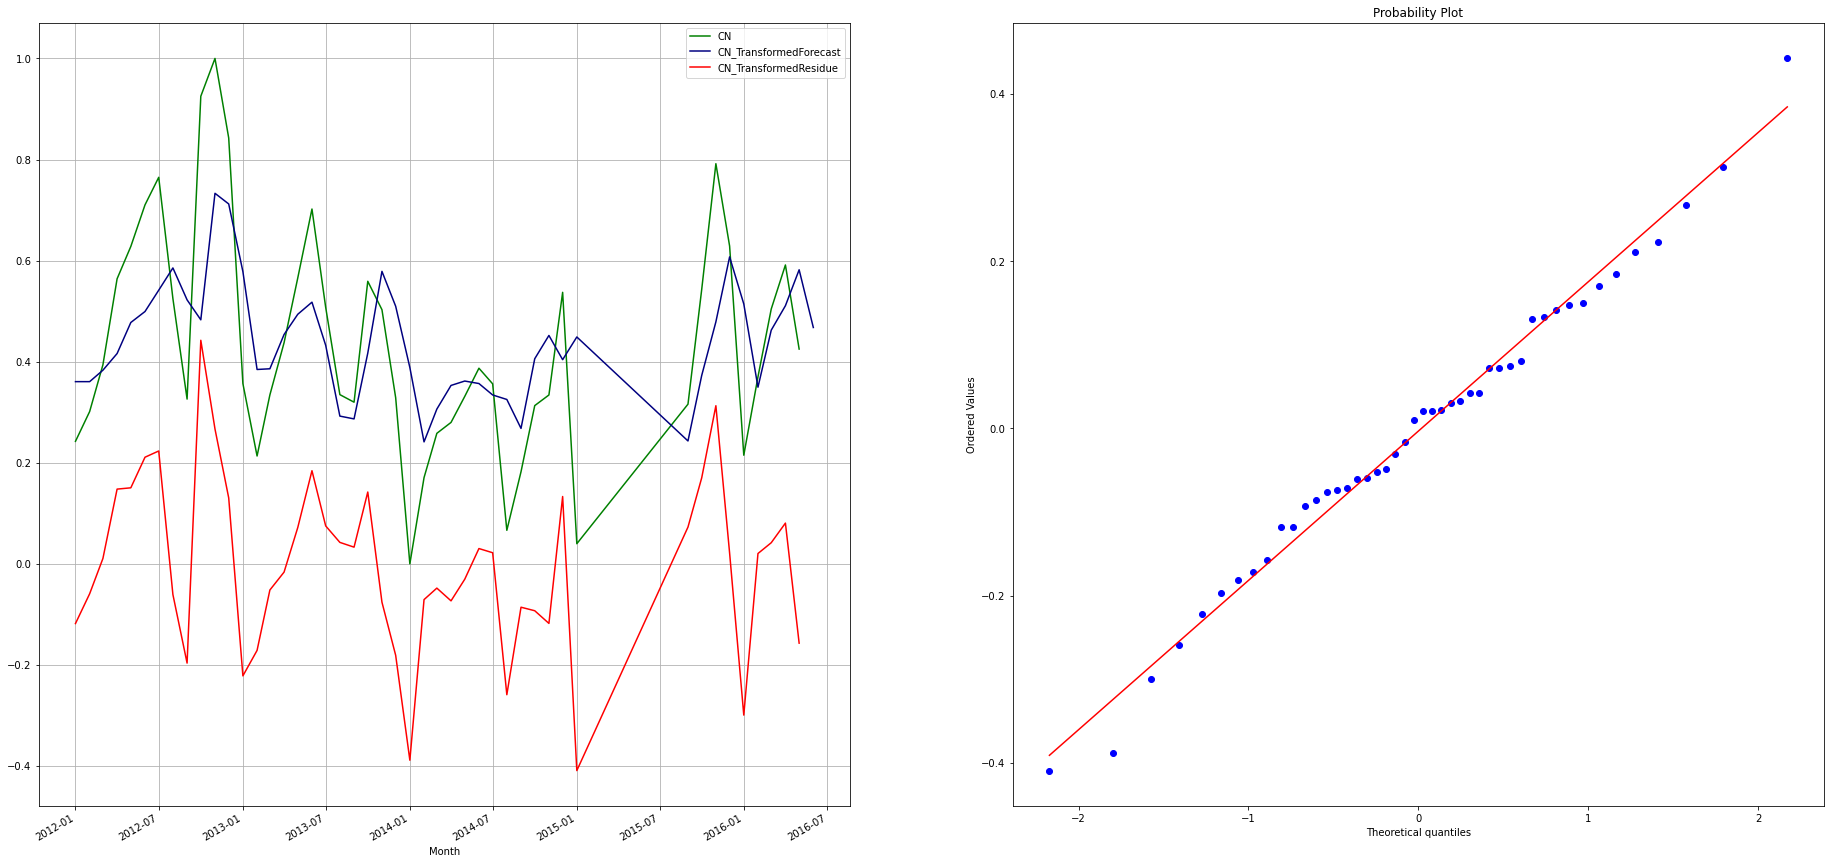

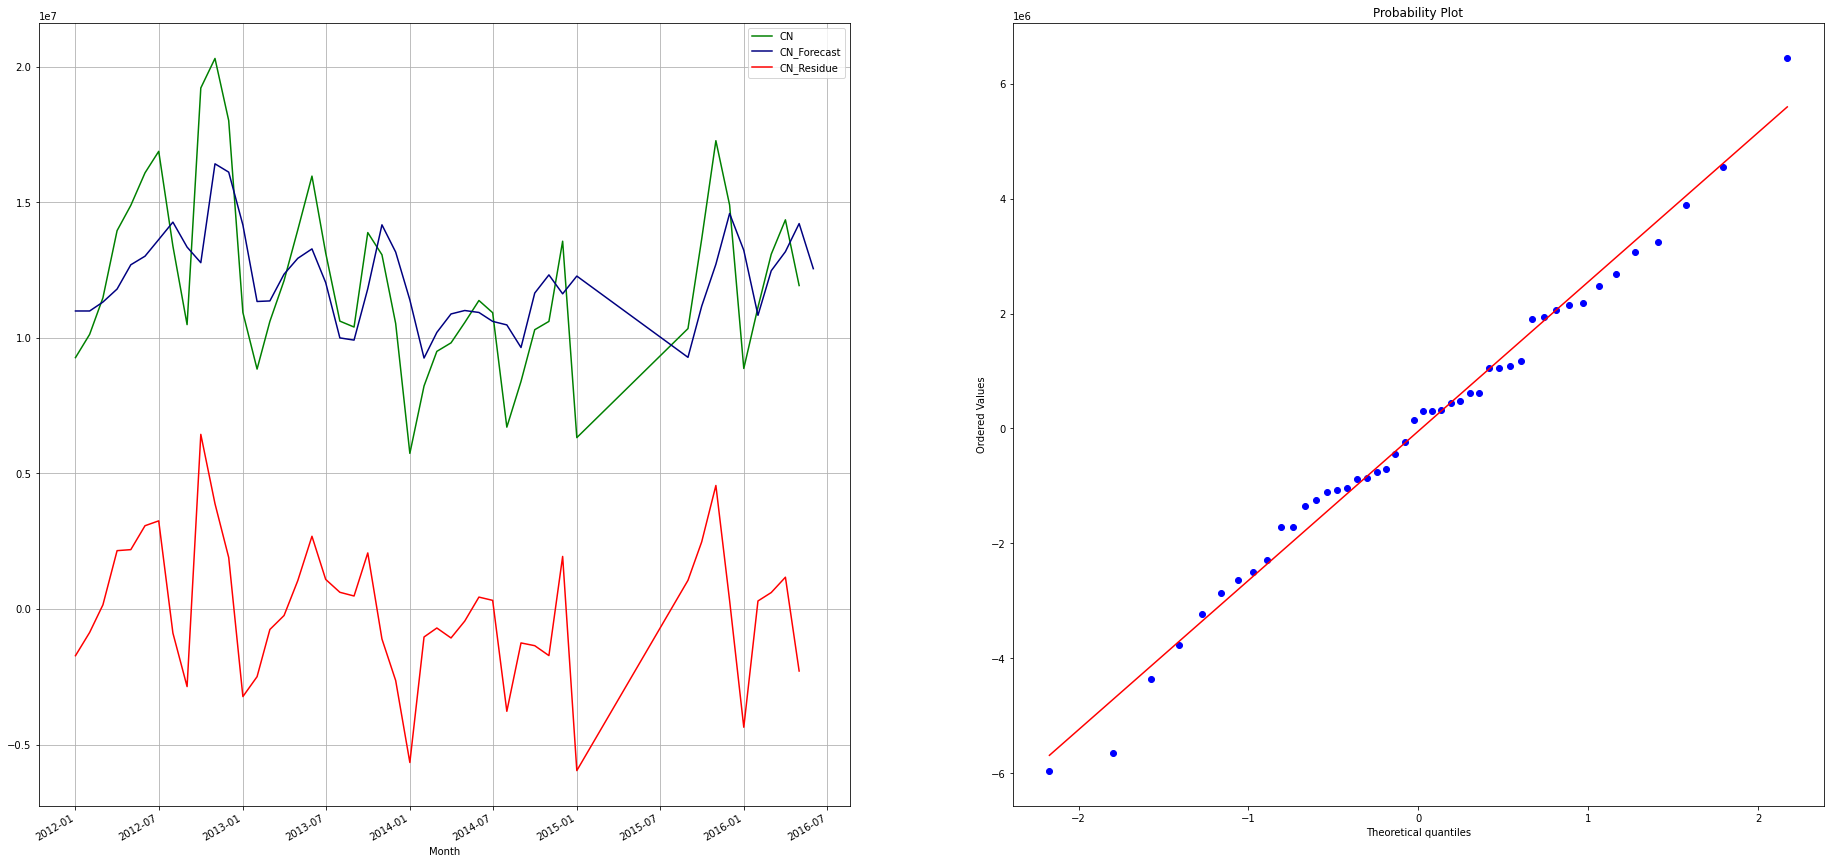

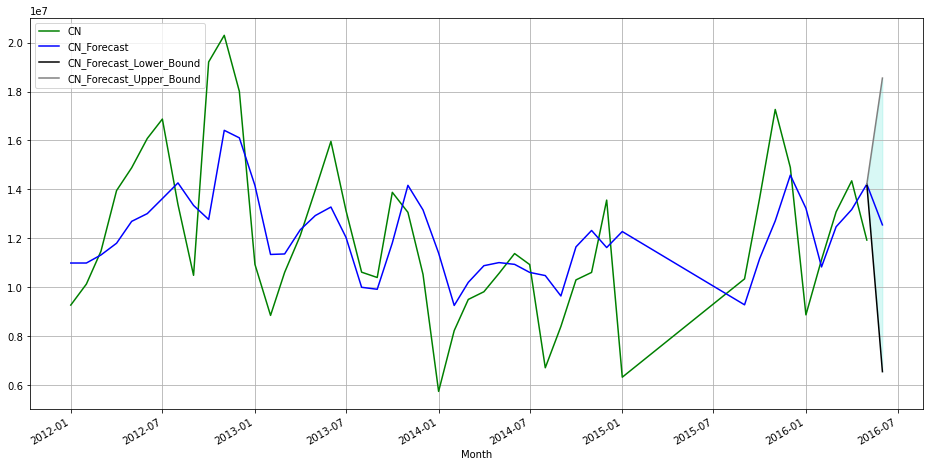

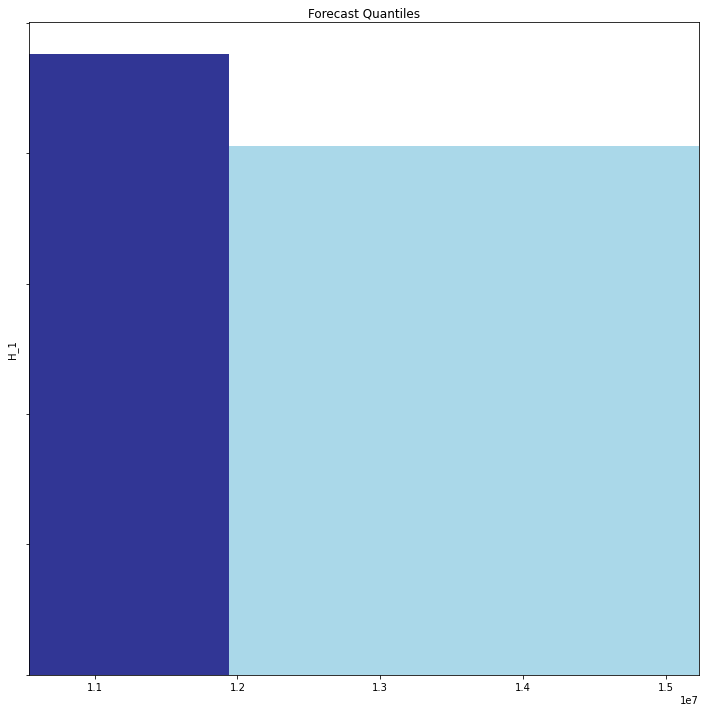

In [29]:
CN_Model.standardPlots()

## Hierarchical Forecast Combinations


### Bottom-Up / Top-Down and Middle-Out Forecasts

In [30]:
lEngine.mOptions.mHierarchicalCombinationMethod = ["BU" , 'TD' , 'MO' , 'OC'];
dfapp_out = lEngine.forecast(train_df, H);


INFO:pyaf.timing:('OPERATION_START', 'HIERARCHICAL_FORECAST')
INFO:pyaf.timing:('OPERATION_START', ('FORECASTING', {'Signals': ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'], 'Horizon': 4}))
/usr/lib/python3/dist-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Month_Normalized_x', 'row_number_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(
/usr/

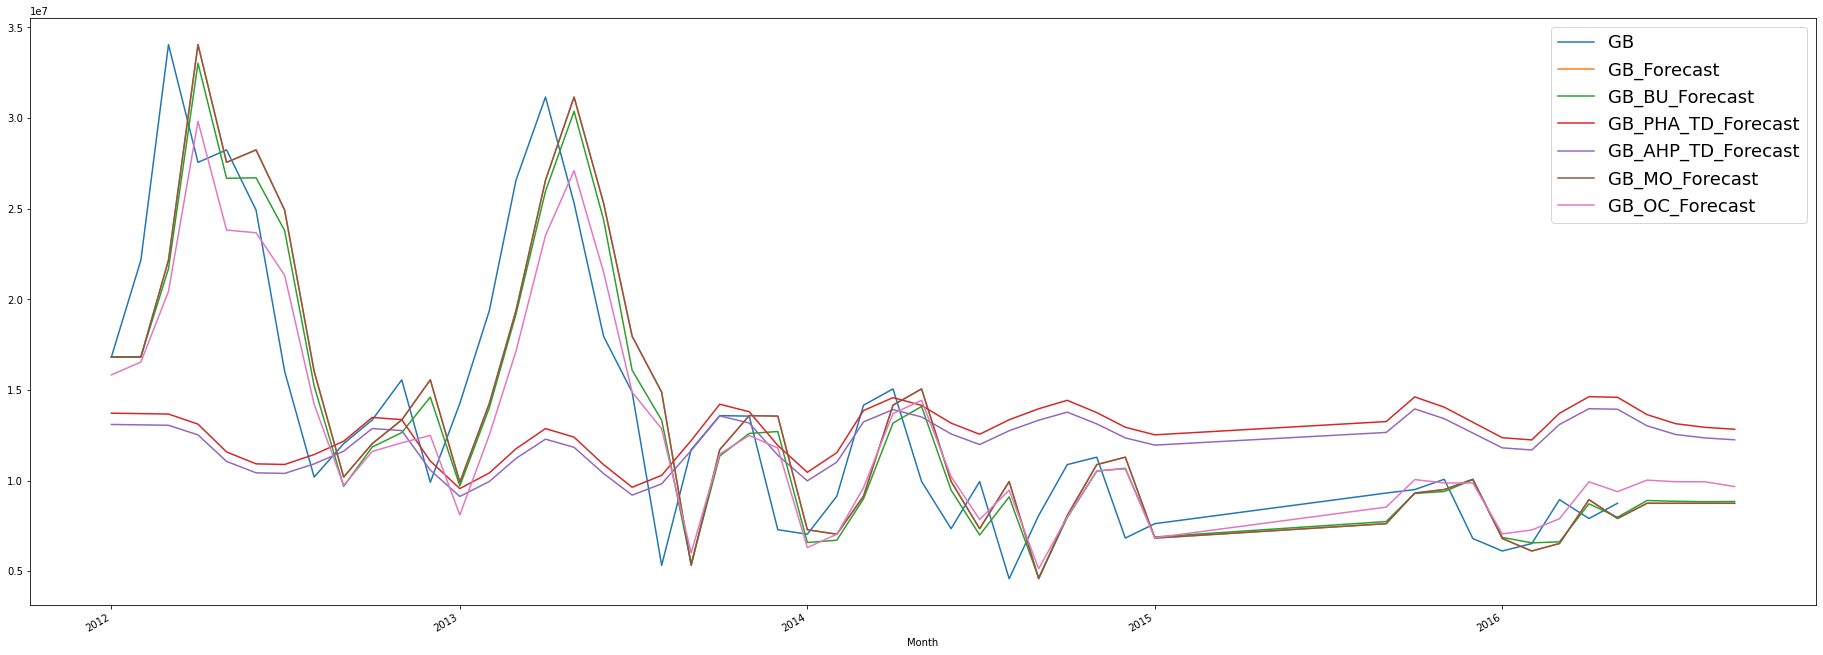

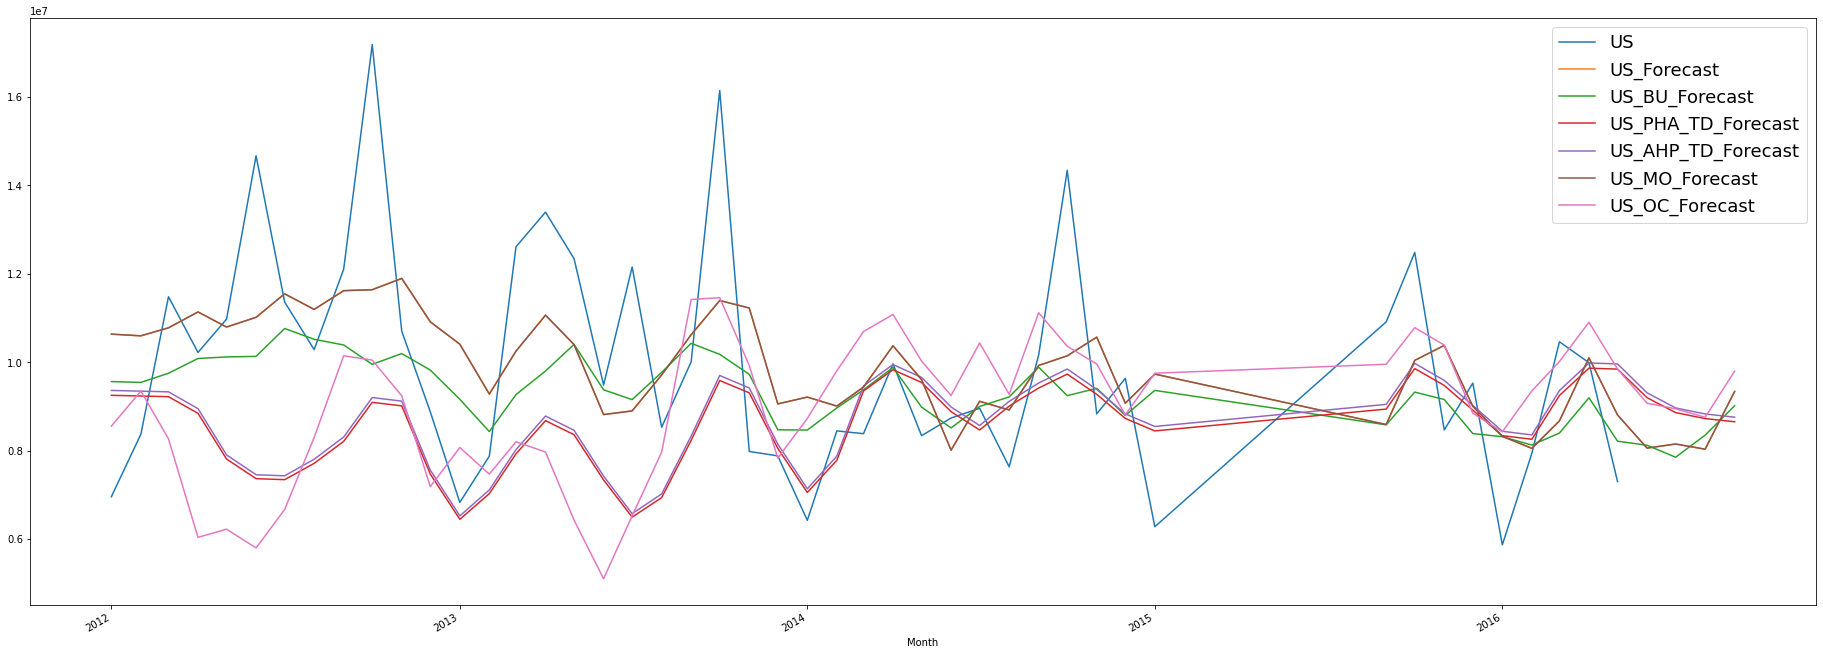

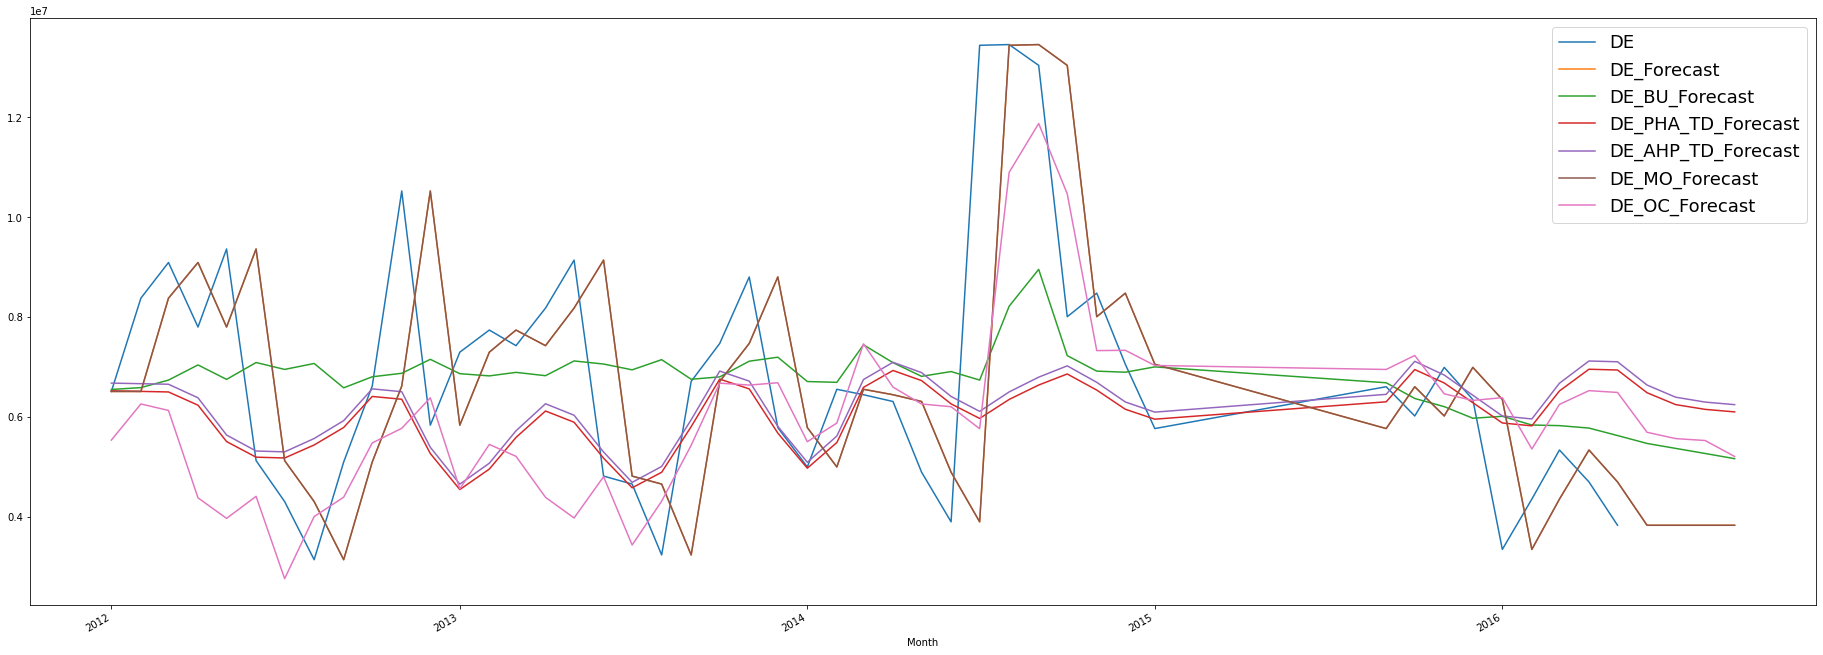

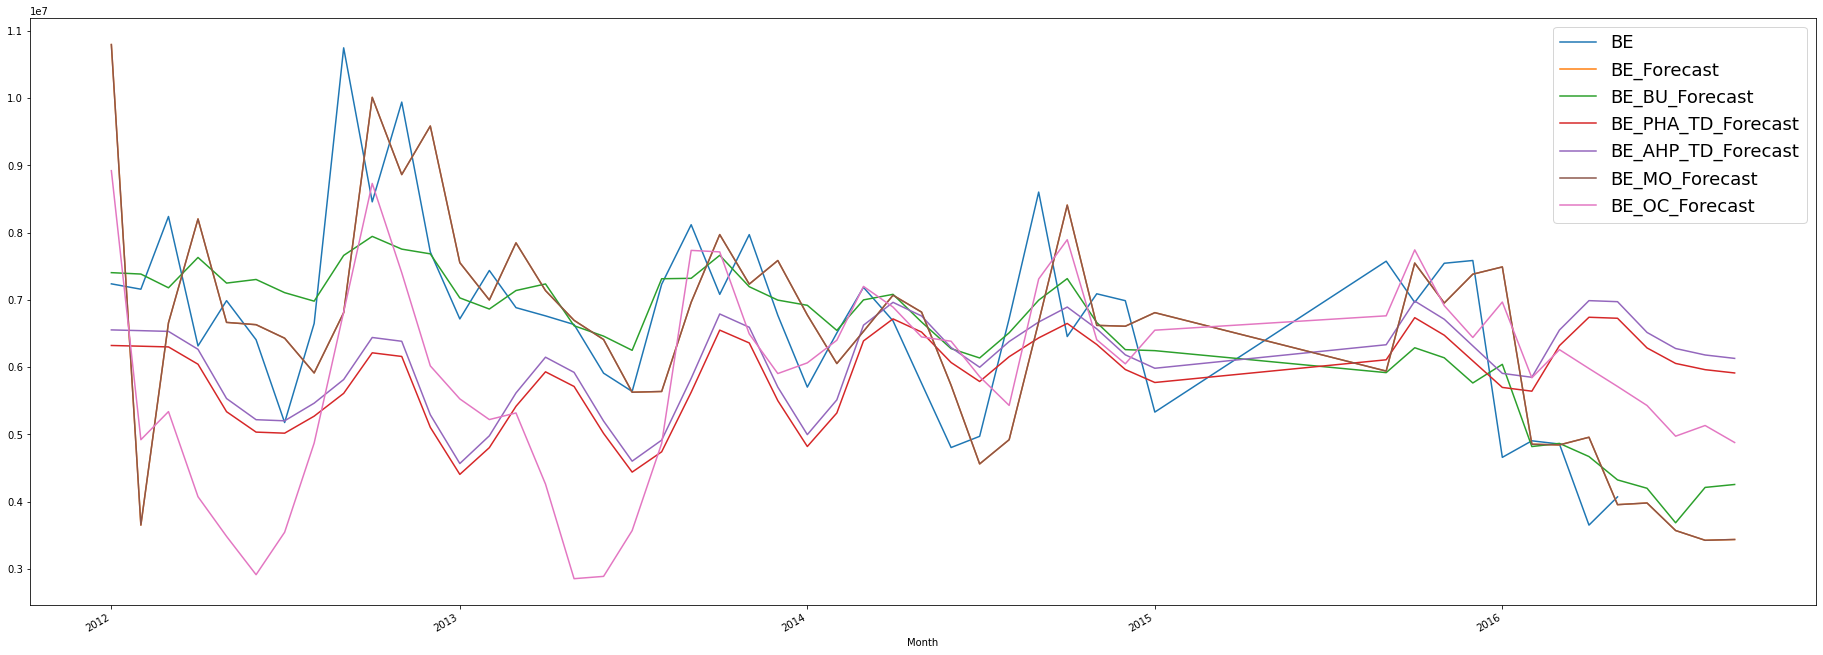

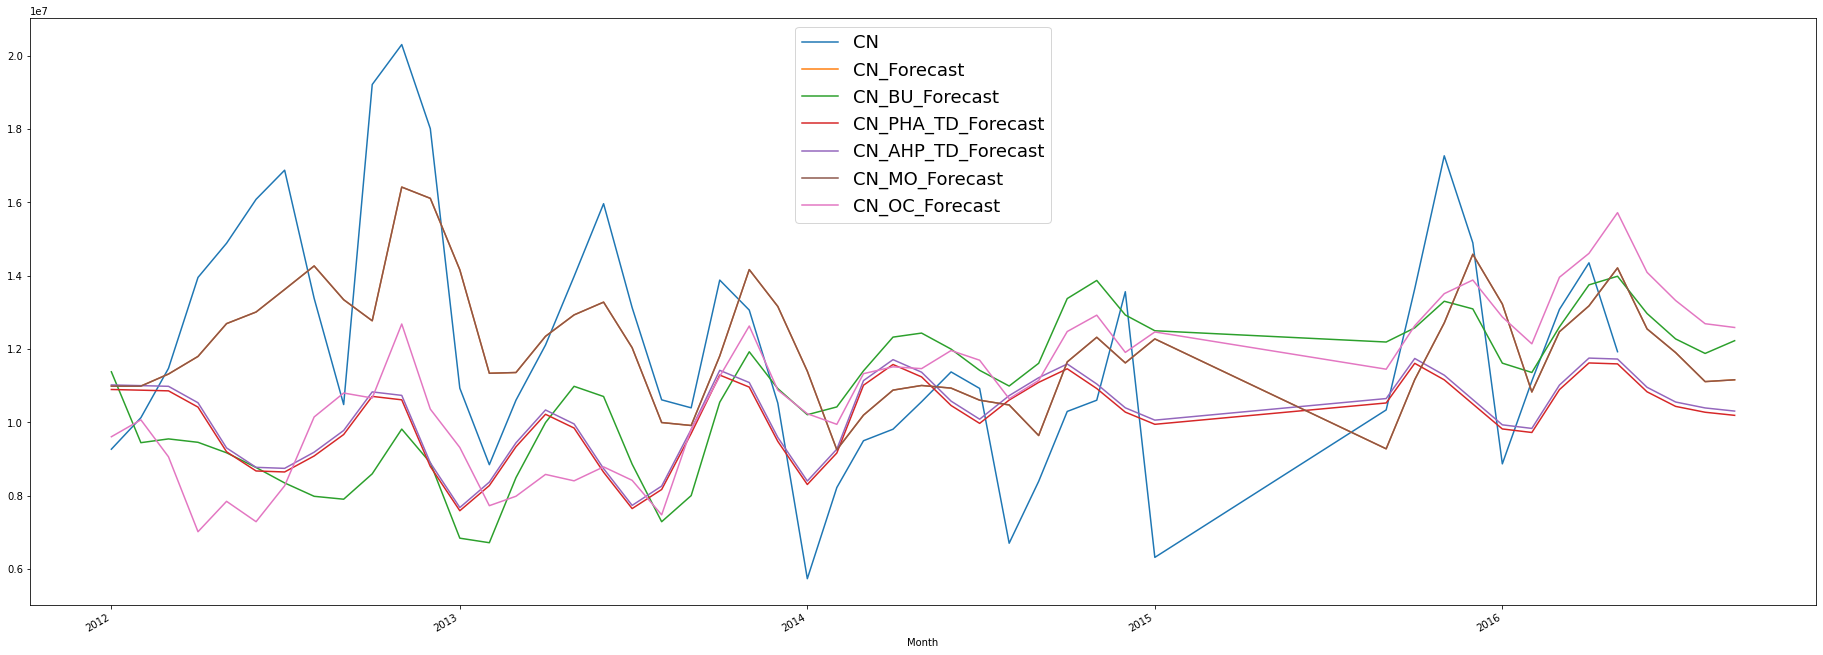

In [31]:
def strip_leading_underscores_if_needed(col_name):
    # this is a workaround for some matplotlib bugs. legend cannot contain names starting with '_'
    patched_name = col_name[2:] if(col_name.startswith('__')) else col_name
    patched_name = patched_name[1:] if(patched_name.startswith('_')) else patched_name
    return patched_name
    

dfapp_out.columns = [strip_leading_underscores_if_needed(col) for col in dfapp_out.columns]
for c in Countries:
    country = c
    dfapp_out.plot('Month' , 
                    [country , country + '_Forecast' , 
                     country + '_BU_Forecast',  
                     country + '_PHA_TD_Forecast',  
                     country + '_AHP_TD_Forecast'  ,  
                     country + '_MO_Forecast' ,
                     country + '_OC_Forecast'  ],
                figsize=(32 , 12)).legend(fontsize=18)

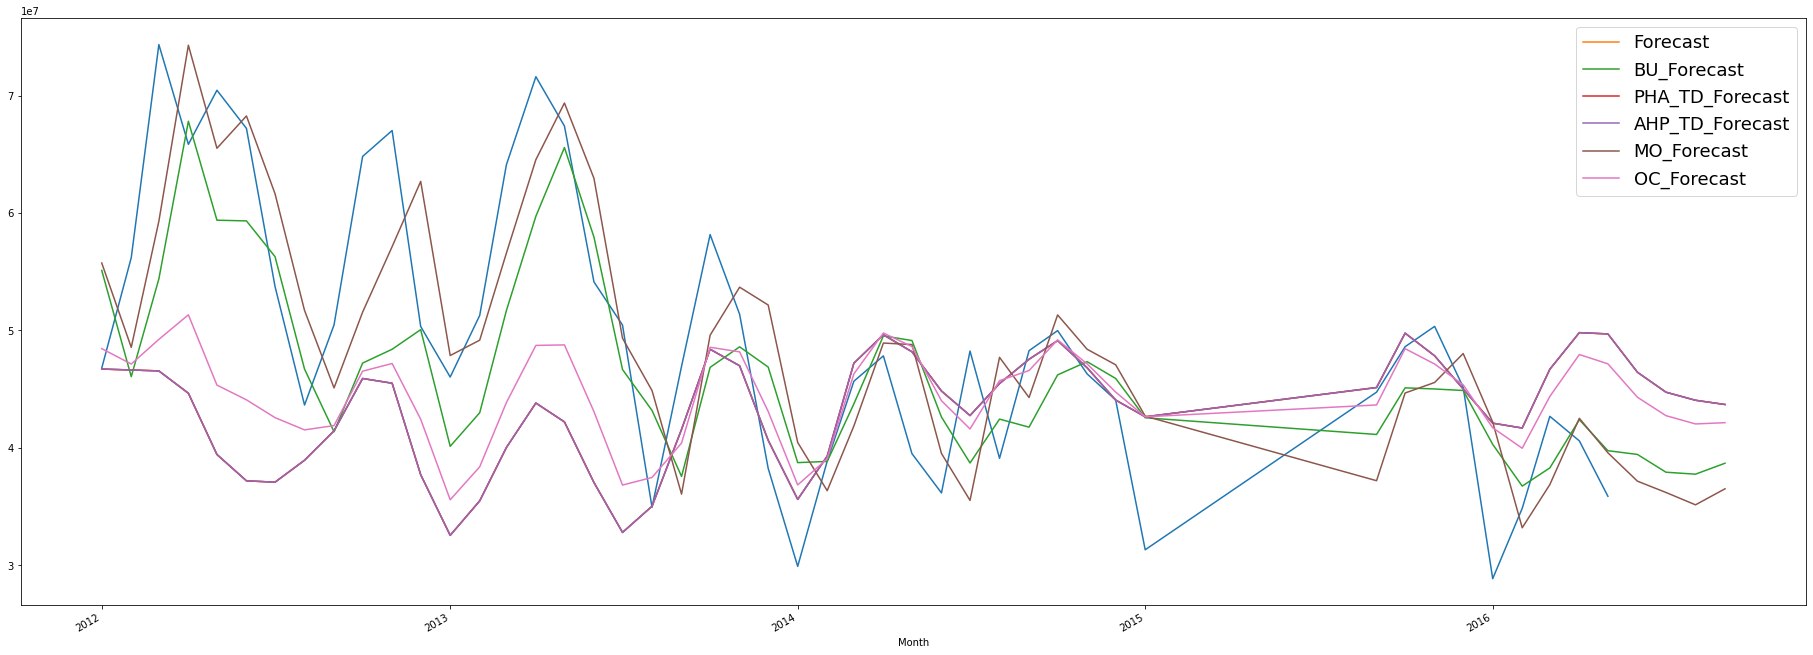

In [32]:
world = ''
dfapp_out.plot('Month' , 
                [world , world + 'Forecast' , 
                 world + 'BU_Forecast',  
                 world + 'PHA_TD_Forecast',  
                 world + 'AHP_TD_Forecast'  ,  
                 world + 'MO_Forecast' ,
                 world + 'OC_Forecast'  ],
                figsize=(32 , 12)).legend(fontsize=18)

In [33]:
dfapp_out.columns

Index(['Month', 'ALSACE_BLANC_BE', 'ALSACE_BLANC_BE_Forecast',
       'ALSACE_BLANC_BE_Forecast_Lower_Bound',
       'ALSACE_BLANC_BE_Forecast_Upper_Bound', 'ALSACE_BLANC_CN',
       'ALSACE_BLANC_CN_Forecast', 'ALSACE_BLANC_CN_Forecast_Lower_Bound',
       'ALSACE_BLANC_CN_Forecast_Upper_Bound', 'ALSACE_BLANC_DE',
       ...
       'ROUGE_CN_OC_Forecast', 'ROUGE_DE_OC_Forecast', 'ROUGE_GB_OC_Forecast',
       'ROUGE_US_OC_Forecast', 'BE_OC_Forecast', 'CN_OC_Forecast',
       'DE_OC_Forecast', 'GB_OC_Forecast', 'US_OC_Forecast', 'OC_Forecast'],
      dtype='object', length=325)